In [25]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 3
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  4.2  0.   0.   3.   2.4  0.   0.  -1.  -1.   0. ]
 [ 4.2  0.   4.2  0.   0.   0.   0.   2.4  0.  -1.  -1.  -1. ]
 [ 4.2  4.2  0.   3.   0.   0.   0.   0.   2.4  0.  -1.  -1. ]
 [ 0.   0.   3.   0.   4.2  4.2  0.   0.   3.   2.4  0.   0. ]
 [ 0.   0.   0.   4.2  0.   4.2  0.   0.   0.   0.   2.4  0. ]
 [ 3.   0.   0.   4.2  4.2  0.   3.   0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   3.   0.   4.2  4.2  0.   0.   3. ]
 [ 0.   2.4  0.   0.   0.   0.   4.2  0.   4.2  0.   0.   0. ]
 [ 0.   0.   2.4  3.   0.   0.   4.2  4.2  0.   3.   0.   0. ]
 [-1.  -1.   0.   2.4  0.   0.   0.   0.   3.   0.   4.2  4.2]
 [-1.  -1.  -1.   0.   2.4  0.   0.   0.   0.   4.2  0.   4.2]
 [ 0.  -1.  -1.   0.   0.   2.4  3.   0.   0.   4.2  4.2  0. ]]
Dn:
[3, 3, 3, 3]


In [27]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [28]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=1, n=100):#n=antal samples
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [29]:
def cost_execution(params):
    params = np.reshape(params, (2, int(len(params)/2)))

    global iterations

    cost = CVaRsamp(params, alpha=a, n=num_of_samples)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))
    
    params_list.append(params)
    cost_list.append(cost)

    iterations += 1
    return cost

In [30]:
alphas = [0.05, 0.10, 0.25, 1.00]
num_of_samples = 32 #number of samples from the quantum computer/probability distribution
initial_params = np.array([[1],[1]], requires_grad = True) #first vector is alphas second is betas, (2,1) for P=1, (2,2) for p=2, (2,3) for p=3...
number_of_tests = 1000 #number of times you want to run the tests for each alpha, for statistical analysis this should be high
tolerance = 0.001 #Tolerance for when minimizer is done optimizing


data_library = {}
for a in alphas:
    print('Alpha is now :'+ str(a))
    print("="*100)
    counter = 0
    prob_list_list = []
    cost_list_list = []
    iter_needed_list = []
    
    for j in range(number_of_tests):
        iterations = 0
        params_list = []
        prob_list = []
        cost_list = []
        
        out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)
        out_params = np.reshape(out["x"], (2, len(initial_params[0])))
        print(out["x"])
        print(out["success"])
        probs = get_probs(out_params)
        ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states
        
        for i in range(len(params_list)):
            p = get_probs(params_list[i])
            prob_list.append(float(np.sum(p[ground_states_i])))

        prob_list_list.append(prob_list)
        cost_list_list.append(cost_list)
        iter_needed_list.append(iterations)
        
        counter+=1
        print(str(iterations) + ' iterations needed. CVaR cost ended at: ' + str(cost_list[-1]))
        print('Try ' + str(j+1) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
        print("="*50)
    
    data = {
      "CVaR cost": cost_list_list,
      "Ground state probability": prob_list_list,
      "Iterations needed": iter_needed_list
    }
    
    var_name = "data_for_alpha_%s" % a
    data_library[var_name] = data
    
        

Alpha is now :0.05
Cost at Step 0: -9.75
[[0.89566663]
 [1.22646548]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 1: Success probability of training:  0.0009071145170426193
Cost at Step 0: -9.55
[[1.00037132]
 [2.0009285 ]]
True
20 iterations needed. CVaR cost ended at: -9.85
Try 2: Success probability of training:  0.0005878521416228738
Cost at Step 0: -8.45
[[0.99976445]
 [2.50097186]]
True
22 iterations needed. CVaR cost ended at: -9.65
Try 3: Success probability of training:  0.0038698250127181737
Cost at Step 0: -9.45
[[1.28239507]
 [1.09339789]]
True
21 iterations needed. CVaR cost ended at: -9.75
Try 4: Success probability of training:  0.002707222703339789
Cost at Step 0: -7.15
[[2.25141409]
 [1.27148378]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 5: Success probability of training:  0.0068025409265677255
Cost at Step 0: -9.35
[[1.94332238]
 [0.97603429]]
True
19 iterations needed. CVaR cost ended at: -4.05
Try 6: Success probability of training:  0.

Cost at Step 0: -9.35
[[1.99953924]
 [1.99911248]]
True
22 iterations needed. CVaR cost ended at: -9.45
Try 38: Success probability of training:  0.0018409673662328518
Cost at Step 0: -9.75
[[0.90972121]
 [0.91249838]]
True
22 iterations needed. CVaR cost ended at: -9.65
Try 39: Success probability of training:  0.0013465431028226904
Cost at Step 0: -8.45
[[1.99953378]
 [1.99911533]]
True
19 iterations needed. CVaR cost ended at: -7.65
Try 40: Success probability of training:  0.0018411402285974255
Cost at Step 0: -9.15
[[2.8331387 ]
 [0.35746467]]
True
23 iterations needed. CVaR cost ended at: -8.25
Try 41: Success probability of training:  0.0015307228053111379
Cost at Step 0: -9.15
[[2.00082995]
 [1.99944216]]
True
20 iterations needed. CVaR cost ended at: -9.25
Try 42: Success probability of training:  0.0018022805422744613
Cost at Step 0: -9.25
[[1.99900009]
 [2.00001309]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 43: Success probability of training:  0.001859490398

Cost at Step 0: -8.55
[[2.]
 [2.]]
True
18 iterations needed. CVaR cost ended at: -9.85
Try 76: Success probability of training:  0.0018288626173691416
Cost at Step 0: -9.25
[[0.64644661]
 [0.64644661]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 77: Success probability of training:  0.0036651618341773193
Cost at Step 0: -8.85
[[1.75615255]
 [0.93729352]]
True
24 iterations needed. CVaR cost ended at: -9.35
Try 78: Success probability of training:  0.0007689226912838577
Cost at Step 0: -9.15
[[2.9707469 ]
 [2.24173894]]
True
20 iterations needed. CVaR cost ended at: -9.25
Try 79: Success probability of training:  0.0030449503131260956
Cost at Step 0: -9.15
[[3.9991021]
 [1.0004402]]
True
25 iterations needed. CVaR cost ended at: -8.85
Try 80: Success probability of training:  0.001937101451073073
Cost at Step 0: -9.65
[[1.23814318]
 [0.92117658]]
True
22 iterations needed. CVaR cost ended at: -8.55
Try 81: Success probability of training:  0.0012742536941048493
Cost at Ste

Cost at Step 0: -8.85
[[1.74741384]
 [0.98429709]]
True
24 iterations needed. CVaR cost ended at: -8.85
Try 114: Success probability of training:  0.0009504009548178026
Cost at Step 0: -8.45
[[ 3.24763781]
 [-0.34842777]]
True
22 iterations needed. CVaR cost ended at: -9.25
Try 115: Success probability of training:  0.0003746523704573617
Cost at Step 0: -9.35
[[1.99913984]
 [2.00051003]]
True
22 iterations needed. CVaR cost ended at: -9.65
Try 116: Success probability of training:  0.0018563722188391718
Cost at Step 0: -9.55
[[0.10481034]
 [2.44656657]]
True
22 iterations needed. CVaR cost ended at: -9.55
Try 117: Success probability of training:  0.00980989267524058
Cost at Step 0: -9.65
[[1.0318675 ]
 [0.99803291]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 118: Success probability of training:  0.0010844325524605914
Cost at Step 0: -9.15
[[0.1861317 ]
 [2.58222906]]
True
22 iterations needed. CVaR cost ended at: -9.35
Try 119: Success probability of training:  0.027619

Cost at Step 0: -8.25
[[2.478616  ]
 [0.85226991]]
True
20 iterations needed. CVaR cost ended at: -9.45
Try 152: Success probability of training:  0.0012066710013849762
Cost at Step 0: -9.05
[[2.97108182]
 [2.24287866]]
True
22 iterations needed. CVaR cost ended at: -9.45
Try 153: Success probability of training:  0.003045739967181508
Cost at Step 0: -9.65
[[5.58018704e-04]
 [1.00082983e+00]]
True
24 iterations needed. CVaR cost ended at: -9.85
Try 154: Success probability of training:  0.0019423722652338216
Cost at Step 0: -9.35
[[0.00542938]
 [4.10584207]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 155: Success probability of training:  0.0018242217112901743
Cost at Step 0: -8.85
[[2.8321659 ]
 [0.49852212]]
True
22 iterations needed. CVaR cost ended at: -8.85
Try 156: Success probability of training:  0.0002495727241319665
Cost at Step 0: -9.75
[[0.99774141]
 [1.00190196]]
True
22 iterations needed. CVaR cost ended at: -9.15
Try 157: Success probability of training:  0

21 iterations needed. CVaR cost ended at: -8.75
Try 189: Success probability of training:  0.0006266307236745979
Cost at Step 0: -8.45
[[1.74073613]
 [1.12476315]]
True
23 iterations needed. CVaR cost ended at: -8.25
Try 190: Success probability of training:  0.0012599659099399904
Cost at Step 0: -9.15
[[2.00099682]
 [1.00007975]]
True
19 iterations needed. CVaR cost ended at: -8.45
Try 191: Success probability of training:  0.0006080106761245466
Cost at Step 0: -9.05
[[2.9805881 ]
 [2.19711611]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 192: Success probability of training:  0.002593263213341729
Cost at Step 0: -9.25
[[2.08268305]
 [0.00438625]]
True
22 iterations needed. CVaR cost ended at: -9.85
Try 193: Success probability of training:  0.001983245261548242
Cost at Step 0: -9.25
[[2.62550361]
 [0.21854279]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 194: Success probability of training:  0.002015518619921038
Cost at Step 0: -9.15
[[2.00096674]
 [2.00025

Cost at Step 0: -8.15
[[2.90822249]
 [0.57997705]]
True
20 iterations needed. CVaR cost ended at: -9.15
Try 227: Success probability of training:  0.001567438142369901
Cost at Step 0: -9.75
[[1.99901418]
 [0.9998322 ]]
True
19 iterations needed. CVaR cost ended at: -9.35
Try 228: Success probability of training:  0.0006238911588213332
Cost at Step 0: -9.65
[[0.70912194]
 [0.72547196]]
True
23 iterations needed. CVaR cost ended at: -8.45
Try 229: Success probability of training:  0.0021794749919372878
Cost at Step 0: -8.85
[[2.22674836]
 [1.37702461]]
True
23 iterations needed. CVaR cost ended at: -9.75
Try 230: Success probability of training:  0.004380384697894939
Cost at Step 0: -9.25
[[0.88983659]
 [2.12867051]]
True
21 iterations needed. CVaR cost ended at: -8.15
Try 231: Success probability of training:  0.0010949389392158801
Cost at Step 0: -9.75
[[1.00768247]
 [0.99723842]]
True
22 iterations needed. CVaR cost ended at: -9.05
Try 232: Success probability of training:  0.00061490

Cost at Step 0: -8.65
[[3.58721071]
 [0.44023474]]
True
22 iterations needed. CVaR cost ended at: -9.75
Try 265: Success probability of training:  0.0038593681511199032
Cost at Step 0: -9.35
[[1.48835295]
 [2.10933087]]
True
22 iterations needed. CVaR cost ended at: -9.15
Try 266: Success probability of training:  0.0020089399943708655
Cost at Step 0: -9.75
[[1.00097566]
 [1.00021929]]
True
20 iterations needed. CVaR cost ended at: -9.75
Try 267: Success probability of training:  0.0005390771055027112
Cost at Step 0: -9.75
[[0.99579112]
 [1.00251857]]
True
23 iterations needed. CVaR cost ended at: -9.35
Try 268: Success probability of training:  0.0004914798656435147
Cost at Step 0: -9.55
[[0.75107921]
 [0.98994466]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 269: Success probability of training:  0.002260300219099327
Cost at Step 0: -9.55
[[0.99937028]
 [1.99922318]]
True
20 iterations needed. CVaR cost ended at: -8.45
Try 270: Success probability of training:  0.0005842

Cost at Step 0: -9.15
[[3.09959151]
 [0.60128109]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 303: Success probability of training:  0.00027991045625448696
Cost at Step 0: -9.75
[[1.00094811]
 [1.99968206]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 304: Success probability of training:  0.0005885821365906928
Cost at Step 0: -9.35
[[2.27505167]
 [0.03941984]]
True
21 iterations needed. CVaR cost ended at: -8.85
Try 305: Success probability of training:  0.0022320532830615385
Cost at Step 0: -8.25
[[0.00623732]
 [2.10535433]]
True
22 iterations needed. CVaR cost ended at: -9.75
Try 306: Success probability of training:  0.002038386074512996
Cost at Step 0: -9.75
[[0.87689939]
 [0.00807908]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 307: Success probability of training:  0.0019571464290331474
Cost at Step 0: -9.65
[[2.00057427]
 [1.99918133]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 308: Success probability of training:  0.001809

24 iterations needed. CVaR cost ended at: -9.55
Try 340: Success probability of training:  0.0006241422622149329
Cost at Step 0: -9.85
[[0.99998674]
 [0.99900009]]
True
21 iterations needed. CVaR cost ended at: -9.55
Try 341: Success probability of training:  0.0005252413472647906
Cost at Step 0: -9.05
[[1.51218066]
 [2.110542  ]]
True
24 iterations needed. CVaR cost ended at: -9.05
Try 342: Success probability of training:  0.0012256806973366128
Cost at Step 0: -9.65
[[0.91348362]
 [1.03552028]]
True
24 iterations needed. CVaR cost ended at: -9.25
Try 343: Success probability of training:  0.0006608448966185637
Cost at Step 0: -9.75
[[1.06277337]
 [1.00953355]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 344: Success probability of training:  0.001962213211134469
Cost at Step 0: -9.35
[[ 2.3757822 ]
 [-0.19018648]]
True
23 iterations needed. CVaR cost ended at: -6.35
Try 345: Success probability of training:  0.00021483796801350448
Cost at Step 0: -8.55
[[2.00542292]
 [2.

Cost at Step 0: -8.85
[[2.00001736]
 [1.99900015]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 378: Success probability of training:  0.001826139520606156
Cost at Step 0: -8.75
[[1.99908109]
 [1.99960553]]
True
22 iterations needed. CVaR cost ended at: -9.65
Try 379: Success probability of training:  0.0018560688380652242
Cost at Step 0: -9.15
[[2.00061282]
 [1.00079022]]
True
19 iterations needed. CVaR cost ended at: -9.55
Try 380: Success probability of training:  0.0006108616719549156
Cost at Step 0: -8.25
[[ 2.7610576 ]
 [-0.81052698]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 381: Success probability of training:  0.006318618472592297
Cost at Step 0: -9.55
[[1.0007938 ]
 [2.00060818]]
True
19 iterations needed. CVaR cost ended at: -9.15
Try 382: Success probability of training:  0.0005887544899724001
Cost at Step 0: -8.65
[[0.87989535]
 [2.47721972]]
True
21 iterations needed. CVaR cost ended at: -8.85
Try 383: Success probability of training:  0.003395

19 iterations needed. CVaR cost ended at: -8.45
Try 415: Success probability of training:  0.00037221542481751966
Cost at Step 0: -9.65
[[0.98576588]
 [1.0038696 ]]
True
24 iterations needed. CVaR cost ended at: -9.65
Try 416: Success probability of training:  0.000419439489255515
Cost at Step 0: -9.75
[[0.97835393]
 [0.97794957]]
True
23 iterations needed. CVaR cost ended at: -9.75
Try 417: Success probability of training:  0.00038592973676163713
Cost at Step 0: -8.55
[[0.90046816]
 [2.99403759]]
True
21 iterations needed. CVaR cost ended at: -9.65
Try 418: Success probability of training:  0.0026297249159243077
Cost at Step 0: -9.75
[[1.24786267]
 [1.03324692]]
True
22 iterations needed. CVaR cost ended at: -9.85
Try 419: Success probability of training:  0.0020023534618348613
Cost at Step 0: -9.15
[[2.0615999 ]
 [1.75772293]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 420: Success probability of training:  0.0013043322547830665
Cost at Step 0: -9.75
[[1.00032621]
 [1.0

Cost at Step 0: -9.15
[[1.99675565]
 [0.99945627]]
True
24 iterations needed. CVaR cost ended at: -9.45
Try 453: Success probability of training:  0.0006422695713393499
Cost at Step 0: -8.45
[[1.00160123]
 [2.03103218]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 454: Success probability of training:  0.0006337103976215171
Cost at Step 0: -9.25
[[2.18621936]
 [0.01721087]]
True
22 iterations needed. CVaR cost ended at: -8.55
Try 455: Success probability of training:  0.00209806290467939
Cost at Step 0: -8.25
[[2.99701481]
 [2.07569729]]
True
21 iterations needed. CVaR cost ended at: -9.65
Try 456: Success probability of training:  0.001204274868526411
Cost at Step 0: -9.35
[[0.89663576]
 [1.93072174]]
True
22 iterations needed. CVaR cost ended at: -9.75
Try 457: Success probability of training:  0.0009676919631121109
Cost at Step 0: -9.55
[[0.70908911]
 [0.59408974]]
True
23 iterations needed. CVaR cost ended at: -9.35
Try 458: Success probability of training:  0.002953328

21 iterations needed. CVaR cost ended at: -9.75
Try 490: Success probability of training:  0.0005499246063370198
Cost at Step 0: -9.25
[[0.82251138]
 [2.51091262]]
True
25 iterations needed. CVaR cost ended at: -9.85
Try 491: Success probability of training:  0.0027787835784228478
Cost at Step 0: -9.75
[[1.00065996]
 [0.9992487 ]]
True
20 iterations needed. CVaR cost ended at: -9.75
Try 492: Success probability of training:  0.0005331394300885273
Cost at Step 0: -7.55
[[2.08791796]
 [1.24128202]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 493: Success probability of training:  0.000361452457113985
Cost at Step 0: -8.75
[[2.31385913]
 [0.56720641]]
True
21 iterations needed. CVaR cost ended at: -9.75
Try 494: Success probability of training:  0.000593367052419624
Cost at Step 0: -9.75
[[1.24757114]
 [0.97333168]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 495: Success probability of training:  0.0015594907550547643
Cost at Step 0: -8.85
[[2.00183698]
 [1.0014

Cost at Step 0: -9.15
[[1.3803519 ]
 [1.21229773]]
True
25 iterations needed. CVaR cost ended at: -9.85
Try 528: Success probability of training:  0.005921649024487895
Cost at Step 0: -9.15
[[1.51411039]
 [2.11364736]]
True
23 iterations needed. CVaR cost ended at: -9.55
Try 529: Success probability of training:  0.001218445542603785
Cost at Step 0: -9.75
[[1.24728057]
 [0.97077029]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 530: Success probability of training:  0.001541577435758056
Cost at Step 0: -8.85
[[1.53715393]
 [2.19033419]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 531: Success probability of training:  0.0014623757826764505
Cost at Step 0: -9.85
[[0.99965622]
 [1.00093905]]
True
21 iterations needed. CVaR cost ended at: -8.85
Try 532: Success probability of training:  0.0005264176472315157
Cost at Step 0: -8.25
[[1.64328294]
 [2.35073441]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 533: Success probability of training:  0.001452178

21 iterations needed. CVaR cost ended at: -9.15
Try 565: Success probability of training:  0.0004500246088203763
Cost at Step 0: -9.65
[[1.05442374]
 [0.9696239 ]]
True
23 iterations needed. CVaR cost ended at: -9.15
Try 566: Success probability of training:  0.0015663911437902123
Cost at Step 0: -9.65
[[0.90170269]
 [1.2291862 ]]
True
19 iterations needed. CVaR cost ended at: -9.15
Try 567: Success probability of training:  0.0008438058407471219
Cost at Step 0: -9.05
[[0.35320237]
 [1.30626849]]
True
25 iterations needed. CVaR cost ended at: -8.45
Try 568: Success probability of training:  0.00010432889110233506
Cost at Step 0: -8.65
[[1.93657872]
 [1.99684974]]
True
22 iterations needed. CVaR cost ended at: -8.85
Try 569: Success probability of training:  0.0032354525066956167
Cost at Step 0: -9.65
[[1.01609477]
 [1.003418  ]]
True
22 iterations needed. CVaR cost ended at: -9.75
Try 570: Success probability of training:  0.0007706780215689442
Cost at Step 0: -8.85
[[2.08120299]
 [1.5

Cost at Step 0: -9.25
[[0.16472475]
 [2.89765359]]
True
27 iterations needed. CVaR cost ended at: -9.65
Try 603: Success probability of training:  0.02119539519019544
Cost at Step 0: -9.45
[[1.2488846]
 [0.9923826]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 604: Success probability of training:  0.0016985029333232494
Cost at Step 0: -8.25
[[2.00097142]
 [2.00023736]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 605: Success probability of training:  0.0017996277624071967
Cost at Step 0: -9.45
[[1.21888811]
 [0.88109407]]
True
20 iterations needed. CVaR cost ended at: -9.85
Try 606: Success probability of training:  0.0012789556206183733
Cost at Step 0: -9.65
[[0.87812789]
 [0.97051142]]
True
21 iterations needed. CVaR cost ended at: -9.65
Try 607: Success probability of training:  0.001906147370901916
Cost at Step 0: -9.55
[[7.36225946e-04]
 [2.09177194e+00]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 608: Success probability of training:  0.001

24 iterations needed. CVaR cost ended at: -9.45
Try 640: Success probability of training:  0.0034611625860537488
Cost at Step 0: -9.35
[[ 0.74961676]
 [-0.00092365]]
True
22 iterations needed. CVaR cost ended at: -8.45
Try 641: Success probability of training:  0.001966928130181908
Cost at Step 0: -9.75
[[0.99933352]
 [2.00074553]]
True
19 iterations needed. CVaR cost ended at: -9.15
Try 642: Success probability of training:  0.0005851396849782537
Cost at Step 0: -9.15
[[2.00017152]
 [1.99901482]]
True
23 iterations needed. CVaR cost ended at: -9.85
Try 643: Success probability of training:  0.0018214699708235193
Cost at Step 0: -9.65
[[1.06284602]
 [1.00714355]]
True
22 iterations needed. CVaR cost ended at: -8.15
Try 644: Success probability of training:  0.001956194895736121
Cost at Step 0: -7.55
[[3.08337367]
 [0.98347733]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 645: Success probability of training:  0.005110604901649782
Cost at Step 0: -8.35
[[5.69482188]
 [0.846

Cost at Step 0: -9.85
[[0.99940144]
 [0.99919892]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 678: Success probability of training:  0.0005195366104990909
Cost at Step 0: -9.65
[[0.50796274]
 [0.90956253]]
True
19 iterations needed. CVaR cost ended at: -9.15
Try 679: Success probability of training:  0.0027456297505793438
Cost at Step 0: -9.55
[[0.00323027]
 [2.09005438]]
True
21 iterations needed. CVaR cost ended at: -8.15
Try 680: Success probability of training:  0.0019966614966231457
Cost at Step 0: -9.65
[[1.0154498 ]
 [0.94008387]]
True
22 iterations needed. CVaR cost ended at: -9.15
Try 681: Success probability of training:  0.0005690445143570071
Cost at Step 0: -8.45
[[3.17626293]
 [0.11968057]]
True
23 iterations needed. CVaR cost ended at: -8.15
Try 682: Success probability of training:  0.0016491889606145688
Cost at Step 0: -9.65
[[0.99931792]
 [2.00073128]]
True
20 iterations needed. CVaR cost ended at: -9.35
Try 683: Success probability of training:  0.000585

Cost at Step 0: -7.25
[[1.99697626]
 [1.06155828]]
True
20 iterations needed. CVaR cost ended at: -9.45
Try 716: Success probability of training:  0.0005897490822045456
Cost at Step 0: -9.15
[[2.49024865]
 [0.41914195]]
True
22 iterations needed. CVaR cost ended at: -9.65
Try 717: Success probability of training:  0.004288265333260443
Cost at Step 0: -8.15
[[0.8154346 ]
 [1.83260862]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 718: Success probability of training:  0.002357479162762281
Cost at Step 0: -9.75
[[1.24972327]
 [0.99141103]]
True
23 iterations needed. CVaR cost ended at: -8.45
Try 719: Success probability of training:  0.0016943289896172264
Cost at Step 0: -9.35
[[0.75064362]
 [3.01583315]]
True
22 iterations needed. CVaR cost ended at: -9.85
Try 720: Success probability of training:  0.005221586710222489
Cost at Step 0: -9.15
[[2.39889682]
 [0.22612768]]
True
20 iterations needed. CVaR cost ended at: -9.85
Try 721: Success probability of training:  0.000561023

Cost at Step 0: -9.05
[[1.00009372]
 [1.9990044 ]]
True
19 iterations needed. CVaR cost ended at: -9.85
Try 754: Success probability of training:  0.0005859503325793937
Cost at Step 0: -8.45
[[1.89163659]
 [1.77563901]]
True
24 iterations needed. CVaR cost ended at: -7.55
Try 755: Success probability of training:  0.002800296250029177
Cost at Step 0: -8.15
[[3.08547719]
 [0.74214472]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 756: Success probability of training:  0.0012472692653206223
Cost at Step 0: -9.65
[[0.93224778]
 [1.24109815]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 757: Success probability of training:  0.0007538266537375698
Cost at Step 0: -9.65
[[0.53846154]
 [0.80769231]]
True
22 iterations needed. CVaR cost ended at: -9.85
Try 758: Success probability of training:  0.004801561971706238
Cost at Step 0: -9.15
[[1.59312969]
 [1.16953476]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 759: Success probability of training:  0.00208192

21 iterations needed. CVaR cost ended at: -8.25
Try 791: Success probability of training:  0.0018246200945337436
Cost at Step 0: -8.55
[[0.90904853]
 [2.9968027 ]]
True
24 iterations needed. CVaR cost ended at: -9.65
Try 792: Success probability of training:  0.0025016443379636748
Cost at Step 0: -9.15
[[0.18720337]
 [2.58158795]]
True
23 iterations needed. CVaR cost ended at: -9.45
Try 793: Success probability of training:  0.027508305004543192
Cost at Step 0: -9.85
[[1.00099173]
 [1.00012838]]
True
20 iterations needed. CVaR cost ended at: -7.55
Try 794: Success probability of training:  0.0005390263680857841
Cost at Step 0: -9.65
[[0.89256021]
 [0.93806457]]
True
24 iterations needed. CVaR cost ended at: -9.35
Try 795: Success probability of training:  0.001668436140981477
Cost at Step 0: -9.65
[[1.00024954]
 [1.99903164]]
True
20 iterations needed. CVaR cost ended at: -8.15
Try 796: Success probability of training:  0.0005863618199283725
Cost at Step 0: -8.35
[[2.00046584]
 [0.9991

Cost at Step 0: -9.45
[[2.42922277]
 [0.15576257]]
True
24 iterations needed. CVaR cost ended at: -9.85
Try 829: Success probability of training:  0.0013534228589827477
Cost at Step 0: -9.15
[[2.33846985]
 [0.48901899]]
True
25 iterations needed. CVaR cost ended at: -9.85
Try 830: Success probability of training:  0.0012248214380433308
Cost at Step 0: -9.65
[[1.2499617 ]
 [0.98515659]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 831: Success probability of training:  0.0016496157632044156
Cost at Step 0: -8.45
[[0.99910913]
 [1.99954574]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 832: Success probability of training:  0.0005838676849470386
Cost at Step 0: -9.35
[[2.00013818]
 [2.00099041]]
True
24 iterations needed. CVaR cost ended at: -9.35
Try 833: Success probability of training:  0.0018268362938089163
Cost at Step 0: -9.75
[[1.23808372]
 [0.92053487]]
True
23 iterations needed. CVaR cost ended at: -9.45
Try 834: Success probability of training:  0.001272

Cost at Step 0: -9.35
[[1.99985697]
 [2.00098972]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 867: Success probability of training:  0.0018354739795549391
Cost at Step 0: -9.15
[[0.98614876]
 [1.02040344]]
True
20 iterations needed. CVaR cost ended at: -9.35
Try 868: Success probability of training:  0.00044750819813623295
Cost at Step 0: -9.75
[[1.00098096]
 [0.99980578]]
True
19 iterations needed. CVaR cost ended at: -8.25
Try 869: Success probability of training:  0.0005380892774046087
Cost at Step 0: -7.15
[[3.09963911]
 [2.87492928]]
True
26 iterations needed. CVaR cost ended at: -9.45
Try 870: Success probability of training:  0.0027461351907994693
Cost at Step 0: -9.75
[[1.00944658]
 [1.0130017 ]]
True
21 iterations needed. CVaR cost ended at: -9.35
Try 871: Success probability of training:  0.0006928869108119596
Cost at Step 0: -9.25
[[1.60812745]
 [2.31041708]]
True
22 iterations needed. CVaR cost ended at: -9.35
Try 872: Success probability of training:  0.00076

21 iterations needed. CVaR cost ended at: -9.15
Try 904: Success probability of training:  0.001752597031216655
Cost at Step 0: -9.75
[[1.00081647]
 [1.00057739]]
True
20 iterations needed. CVaR cost ended at: -8.25
Try 905: Success probability of training:  0.0005382051767044741
Cost at Step 0: -9.65
[[7.83806930e-04]
 [9.99378995e-01]]
True
22 iterations needed. CVaR cost ended at: -9.45
Try 906: Success probability of training:  0.0019378654158722487
Cost at Step 0: -9.85
[[0.99927818]
 [0.99930792]]
True
20 iterations needed. CVaR cost ended at: -9.55
Try 907: Success probability of training:  0.0005185094708390898
Cost at Step 0: -9.75
[[1.24936304]
 [0.98252161]]
True
20 iterations needed. CVaR cost ended at: -9.85
Try 908: Success probability of training:  0.0016287935988153442
Cost at Step 0: -9.25
[[2.05811411]
 [2.02198312]]
True
24 iterations needed. CVaR cost ended at: -9.45
Try 909: Success probability of training:  0.00037623082099121974
Cost at Step 0: -9.65
[[1.25047923

Cost at Step 0: -9.15
[[2.0791769 ]
 [0.77793472]]
True
23 iterations needed. CVaR cost ended at: -8.45
Try 942: Success probability of training:  0.0008302255689842874
Cost at Step 0: -9.75
[[0.99914212]
 [1.00051385]]
True
19 iterations needed. CVaR cost ended at: -9.35
Try 943: Success probability of training:  0.0005199518240524019
Cost at Step 0: -9.85
[[1.00091488]
 [0.99959628]]
True
21 iterations needed. CVaR cost ended at: -9.75
Try 944: Success probability of training:  0.0005368248786440147
Cost at Step 0: -8.45
[[2.60879685]
 [0.20778194]]
True
22 iterations needed. CVaR cost ended at: -9.35
Try 945: Success probability of training:  0.0018649405721496708
Cost at Step 0: -9.65
[[0.4654283 ]
 [0.15532663]]
True
21 iterations needed. CVaR cost ended at: -8.55
Try 946: Success probability of training:  1.3145908416092165e-05
Cost at Step 0: -9.35
[[2.31656563]
 [0.0522579 ]]
True
22 iterations needed. CVaR cost ended at: -7.55
Try 947: Success probability of training:  0.00225

Cost at Step 0: -9.35
[[1.99028553]
 [1.0131515 ]]
True
20 iterations needed. CVaR cost ended at: -8.85
Try 980: Success probability of training:  0.0006981397999387824
Cost at Step 0: -9.85
[[1.00089321]
 [1.00044964]]
True
19 iterations needed. CVaR cost ended at: -9.75
Try 981: Success probability of training:  0.0005387387871476921
Cost at Step 0: -9.35
[[ 2.94606381]
 [-0.62543666]]
True
22 iterations needed. CVaR cost ended at: -9.45
Try 982: Success probability of training:  0.004078428578423273
Cost at Step 0: -9.65
[[0.79176237]
 [0.87164579]]
True
26 iterations needed. CVaR cost ended at: -9.75
Try 983: Success probability of training:  0.003158310810172541
Cost at Step 0: -9.25
[[ 1.86466697]
 [-0.16135042]]
True
21 iterations needed. CVaR cost ended at: -9.85
Try 984: Success probability of training:  0.002356172416293944
Cost at Step 0: -9.25
[[1.13213353]
 [1.75256803]]
True
20 iterations needed. CVaR cost ended at: -9.65
Try 985: Success probability of training:  0.00274

Cost at Step 0: -8.683333333333334
[[0.99669223]
 [2.00041967]]
True
23 iterations needed. CVaR cost ended at: -8.85
Try 16: Success probability of training:  0.0005792679480338076
Cost at Step 0: -9.416666666666666
[[1.00095394]
 [1.00029998]]
True
20 iterations needed. CVaR cost ended at: -8.65
Try 17: Success probability of training:  0.0005390387152877757
Cost at Step 0: -7.95
[[2.48817717]
 [0.89454569]]
True
21 iterations needed. CVaR cost ended at: -6.216666666666668
Try 18: Success probability of training:  0.0013052238500956786
Cost at Step 0: -9.35
[[0.78557376]
 [0.54736648]]
True
20 iterations needed. CVaR cost ended at: -7.583333333333333
Try 19: Success probability of training:  0.0023899654939588165
Cost at Step 0: -8.450000000000001
[[2.10374358]
 [0.92967061]]
True
22 iterations needed. CVaR cost ended at: -8.25
Try 20: Success probability of training:  0.00021201824768341413
Cost at Step 0: -9.183333333333335
[[0.97231001]
 [0.50038209]]
True
21 iterations needed. CVa

23 iterations needed. CVaR cost ended at: -8.683333333333334
Try 50: Success probability of training:  0.0010500810170339801
Cost at Step 0: -9.15
[[0.99923799]
 [2.00064757]]
True
19 iterations needed. CVaR cost ended at: -8.516666666666666
Try 51: Success probability of training:  0.0005848484673030318
Cost at Step 0: -9.116666666666667
[[-0.10579625]
 [ 0.79728674]]
True
22 iterations needed. CVaR cost ended at: -9.283333333333333
Try 52: Success probability of training:  0.004759162528951107
Cost at Step 0: -8.049999999999999
[[1.87938781]
 [2.03038483]]
True
21 iterations needed. CVaR cost ended at: -8.85
Try 53: Success probability of training:  0.0034893087961818557
Cost at Step 0: -8.316666666666668
[[0.0310216 ]
 [2.04155728]]
True
25 iterations needed. CVaR cost ended at: -8.316666666666666
Try 54: Success probability of training:  0.001894128949714465
Cost at Step 0: -9.616666666666667
[[1.24833672]
 [0.97075804]]
True
21 iterations needed. CVaR cost ended at: -8.85
Try 55: 

Cost at Step 0: -7.45
[[2.02755653]
 [0.98398249]]
True
21 iterations needed. CVaR cost ended at: -8.55
Try 85: Success probability of training:  0.0004478666400155949
Cost at Step 0: -8.383333333333333
[[1.98562378]
 [1.00285374]]
True
20 iterations needed. CVaR cost ended at: -9.049999999999999
Try 86: Success probability of training:  0.0007387293700589566
Cost at Step 0: -8.616666666666667
[[ 2.0901298 ]
 [-0.13340568]]
True
21 iterations needed. CVaR cost ended at: -9.35
Try 87: Success probability of training:  0.0009201960224833201
Cost at Step 0: -8.616666666666667
[[0.76947206]
 [1.83830049]]
True
24 iterations needed. CVaR cost ended at: -8.816666666666666
Try 88: Success probability of training:  0.00361261167438035
Cost at Step 0: -8.85
[[2.16460039]
 [0.5011399 ]]
True
26 iterations needed. CVaR cost ended at: -8.383333333333333
Try 89: Success probability of training:  0.0035356793400646625
Cost at Step 0: -9.25
[[0.87723975]
 [0.96606994]]
True
26 iterations needed. CVaR

30 iterations needed. CVaR cost ended at: -8.549999999999999
Try 119: Success probability of training:  0.0007677892205014811
Cost at Step 0: -8.983333333333333
[[2.00031564]
 [1.00094888]]
True
20 iterations needed. CVaR cost ended at: -8.783333333333333
Try 120: Success probability of training:  0.0006131936040851636
Cost at Step 0: -8.516666666666667
[[2.17239869]
 [1.17299145]]
True
21 iterations needed. CVaR cost ended at: -9.049999999999999
Try 121: Success probability of training:  0.0013899493986125869
Cost at Step 0: -8.716666666666667
[[2.02553486]
 [1.05751882]]
True
21 iterations needed. CVaR cost ended at: -8.35
Try 122: Success probability of training:  0.000359262369105048
Cost at Step 0: -9.35
[[0.86911248]
 [0.98320147]]
True
24 iterations needed. CVaR cost ended at: -8.85
Try 123: Success probability of training:  0.002103532316940327
Cost at Step 0: -8.583333333333334
[[2.44412219]
 [1.12165527]]
True
25 iterations needed. CVaR cost ended at: -8.416666666666666
Try 1

Cost at Step 0: -8.450000000000001
[[0.99962657]
 [1.99907234]]
True
22 iterations needed. CVaR cost ended at: -8.283333333333333
Try 154: Success probability of training:  0.0005848300851967836
Cost at Step 0: -8.983333333333333
[[0.98606523]
 [0.91004636]]
True
24 iterations needed. CVaR cost ended at: -8.216666666666667
Try 155: Success probability of training:  0.00042142947110398814
Cost at Step 0: -9.116666666666667
[[1.50128188]
 [1.11613688]]
True
22 iterations needed. CVaR cost ended at: -9.616666666666667
Try 156: Success probability of training:  0.0013462305156096413
Cost at Step 0: -9.316666666666668
[[1.20246766]
 [0.85808412]]
True
20 iterations needed. CVaR cost ended at: -7.783333333333334
Try 157: Success probability of training:  0.0015166573911816437
Cost at Step 0: -7.25
[[2.23637769]
 [2.97285675]]
True
24 iterations needed. CVaR cost ended at: -7.783333333333334
Try 158: Success probability of training:  0.00016802607262202235
Cost at Step 0: -9.083333333333334
[

[[2.12923254]
 [0.99742365]]
True
20 iterations needed. CVaR cost ended at: -8.316666666666666
Try 188: Success probability of training:  0.0002931287208624337
Cost at Step 0: -7.1499999999999995
[[2.49169541]
 [0.91391582]]
True
21 iterations needed. CVaR cost ended at: -8.216666666666667
Try 189: Success probability of training:  0.0013814572108706304
Cost at Step 0: -7.95
[[2.07687299]
 [0.90256223]]
True
23 iterations needed. CVaR cost ended at: -7.75
Try 190: Success probability of training:  0.00036659332833758696
Cost at Step 0: -9.216666666666667
[[1.00064937]
 [0.99923952]]
True
19 iterations needed. CVaR cost ended at: -8.016666666666666
Try 191: Success probability of training:  0.0005330003095461537
Cost at Step 0: -8.783333333333333
[[1.38884514]
 [2.31335994]]
True
21 iterations needed. CVaR cost ended at: -9.183333333333334
Try 192: Success probability of training:  0.005658072883149481
Cost at Step 0: -8.983333333333333
[[0.99044155]
 [1.02942661]]
True
22 iterations ne

23 iterations needed. CVaR cost ended at: -8.250000000000002
Try 222: Success probability of training:  0.0025813643270958925
Cost at Step 0: -8.983333333333333
[[1.15678448]
 [1.23575289]]
True
23 iterations needed. CVaR cost ended at: -8.283333333333333
Try 223: Success probability of training:  0.0018721150162994036
Cost at Step 0: -9.450000000000001
[[1.00086374]
 [0.99949606]]
True
19 iterations needed. CVaR cost ended at: -8.916666666666666
Try 224: Success probability of training:  0.0005360052956462158
Cost at Step 0: -8.116666666666667
[[1.18933065]
 [2.30655922]]
True
25 iterations needed. CVaR cost ended at: -8.916666666666668
Try 225: Success probability of training:  0.0029036169369714873
Cost at Step 0: -8.983333333333333
[[1.98726171]
 [0.97974546]]
True
20 iterations needed. CVaR cost ended at: -8.483333333333333
Try 226: Success probability of training:  0.0007066100863235126
Cost at Step 0: -9.450000000000001
[[0.99971663]
 [0.99778654]]
True
20 iterations needed. CVa

23 iterations needed. CVaR cost ended at: -8.549999999999999
Try 256: Success probability of training:  0.0001441140556946809
Cost at Step 0: -6.316666666666666
[[2.98755535]
 [0.82506625]]
True
23 iterations needed. CVaR cost ended at: -8.816666666666668
Try 257: Success probability of training:  0.004546623129980546
Cost at Step 0: -8.516666666666666
[[2.20434807]
 [0.14625044]]
True
24 iterations needed. CVaR cost ended at: -7.8500000000000005
Try 258: Success probability of training:  0.0019552088869887307
Cost at Step 0: -8.516666666666666
[[2.00039145]
 [2.0009202 ]]
True
20 iterations needed. CVaR cost ended at: -8.316666666666668
Try 259: Success probability of training:  0.0018188992338419587
Cost at Step 0: -5.583333333333333
[[2.00039609]
 [1.00091821]]
True
19 iterations needed. CVaR cost ended at: -7.116666666666667
Try 260: Success probability of training:  0.0006125579210182394
Cost at Step 0: -9.083333333333334
[[1.9991804 ]
 [1.00057294]]
True
20 iterations needed. CVa

Cost at Step 0: -8.383333333333333
[[2.07843003]
 [0.08865056]]
True
23 iterations needed. CVaR cost ended at: -9.616666666666667
Try 290: Success probability of training:  0.002440950561771922
Cost at Step 0: -8.649999999999999
[[1.95606762]
 [2.08523156]]
True
24 iterations needed. CVaR cost ended at: -8.983333333333333
Try 291: Success probability of training:  0.003876468033875107
Cost at Step 0: -9.316666666666666
[[0.97920416]
 [0.97538459]]
True
22 iterations needed. CVaR cost ended at: -9.316666666666666
Try 292: Success probability of training:  0.00038746813973245366
Cost at Step 0: -8.95
[[0.84728008]
 [0.64123814]]
True
26 iterations needed. CVaR cost ended at: -7.05
Try 293: Success probability of training:  0.001801094312658445
Cost at Step 0: -9.049999999999999
[[1.30310636]
 [0.93527552]]
True
24 iterations needed. CVaR cost ended at: -9.65
Try 294: Success probability of training:  0.0013752504623809171
Cost at Step 0: -8.85
[[2.00580052]
 [0.9946124 ]]
True
19 iterati

22 iterations needed. CVaR cost ended at: -9.149999999999999
Try 324: Success probability of training:  0.0010784130633938911
Cost at Step 0: -8.316666666666666
[[2.00033979]
 [0.99773569]]
True
20 iterations needed. CVaR cost ended at: -8.35
Try 325: Success probability of training:  0.000613747097695795
Cost at Step 0: -8.816666666666666
[[1.00016463]
 [2.00098636]]
True
20 iterations needed. CVaR cost ended at: -8.183333333333335
Try 326: Success probability of training:  0.0005873577284303704
Cost at Step 0: -9.016666666666666
[[1.21438092]
 [0.85512128]]
True
22 iterations needed. CVaR cost ended at: -8.05
Try 327: Success probability of training:  0.0014146229125383144
Cost at Step 0: -9.416666666666666
[[0.81145789]
 [1.16448389]]
True
22 iterations needed. CVaR cost ended at: -9.083333333333334
Try 328: Success probability of training:  0.002453480592753577
Cost at Step 0: -6.916666666666667
[[0.72420503]
 [1.99285609]]
True
23 iterations needed. CVaR cost ended at: -8.81666666

Cost at Step 0: -7.783333333333334
[[2.47736266]
 [0.69888658]]
True
21 iterations needed. CVaR cost ended at: -8.950000000000001
Try 359: Success probability of training:  0.0017001985130345794
Cost at Step 0: -9.083333333333332
[[2.06625054]
 [0.89238221]]
True
21 iterations needed. CVaR cost ended at: -8.45
Try 360: Success probability of training:  0.00044000368475424355
Cost at Step 0: -8.15
[[ 2.81518354]
 [-0.66550106]]
True
23 iterations needed. CVaR cost ended at: -9.283333333333333
Try 361: Success probability of training:  0.003941410331392418
Cost at Step 0: -8.783333333333333
[[0.98626581]
 [1.93533615]]
True
21 iterations needed. CVaR cost ended at: -8.816666666666665
Try 362: Success probability of training:  0.0006230089091269629
Cost at Step 0: -8.65
[[1.9994651 ]
 [1.99915508]]
True
20 iterations needed. CVaR cost ended at: -8.783333333333333
Try 363: Success probability of training:  0.0018433237327680832
Cost at Step 0: -7.916666666666667
[[2.64554814]
 [2.71808895]

Cost at Step 0: -9.583333333333334
[[1.23846064]
 [0.8945917 ]]
True
22 iterations needed. CVaR cost ended at: -7.3500000000000005
Try 393: Success probability of training:  0.0012358863499360236
Cost at Step 0: -9.316666666666668
[[1.20050538]
 [0.85066863]]
True
21 iterations needed. CVaR cost ended at: -8.916666666666666
Try 394: Success probability of training:  0.0015910366612235363
Cost at Step 0: -7.8500000000000005
[[0.03274453]
 [2.1058023 ]]
True
22 iterations needed. CVaR cost ended at: -8.683333333333334
Try 395: Success probability of training:  0.002042646110694638
Cost at Step 0: -9.65
[[0.99924413]
 [1.00065472]]
True
20 iterations needed. CVaR cost ended at: -8.95
Try 396: Success probability of training:  0.0005213578743740442
Cost at Step 0: -8.783333333333333
[[ 2.8429602 ]
 [-0.90118606]]
True
25 iterations needed. CVaR cost ended at: -8.916666666666666
Try 397: Success probability of training:  0.00264817341712463
Cost at Step 0: -8.616666666666667
[[2.66622247]
 

[[3.33658622]
 [0.09669861]]
True
21 iterations needed. CVaR cost ended at: -8.55
Try 427: Success probability of training:  0.002217614905315816
Cost at Step 0: -8.983333333333334
[[ 0.82330612]
 [-0.0223648 ]]
True
23 iterations needed. CVaR cost ended at: -8.983333333333333
Try 428: Success probability of training:  0.002131515797685812
Cost at Step 0: -8.716666666666667
[[1.22973665]
 [0.90544378]]
True
23 iterations needed. CVaR cost ended at: -8.25
Try 429: Success probability of training:  0.0012363556807406027
Cost at Step 0: -9.35
[[1.06006374]
 [0.97951498]]
True
20 iterations needed. CVaR cost ended at: -8.916666666666666
Try 430: Success probability of training:  0.001772192005305585
Cost at Step 0: -9.216666666666667
[[1.74940708]
 [0.98754261]]
True
20 iterations needed. CVaR cost ended at: -8.316666666666668
Try 431: Success probability of training:  0.0009150361686159585
Cost at Step 0: -8.683333333333334
[[-0.06391764]
 [ 1.57692037]]
True
21 iterations needed. CVaR co

19 iterations needed. CVaR cost ended at: -8.483333333333333
Try 461: Success probability of training:  0.0005875282798324358
Cost at Step 0: -8.816666666666666
[[2.00048585]
 [0.87411834]]
True
22 iterations needed. CVaR cost ended at: -5.3500000000000005
Try 462: Success probability of training:  0.0005252686274438321
Cost at Step 0: -8.75
[[1.76405708]
 [2.75061398]]
True
23 iterations needed. CVaR cost ended at: -9.25
Try 463: Success probability of training:  0.0041112181206813736
Cost at Step 0: -8.883333333333333
[[0.91795491]
 [1.17732235]]
True
23 iterations needed. CVaR cost ended at: -6.45
Try 464: Success probability of training:  0.0005812774290540071
Cost at Step 0: -9.616666666666665
[[0.99959965]
 [1.00091636]]
True
19 iterations needed. CVaR cost ended at: -8.85
Try 465: Success probability of training:  0.0005257573956635233
Cost at Step 0: -9.016666666666667
[[2.03783007]
 [1.49958352]]
True
23 iterations needed. CVaR cost ended at: -8.683333333333334
Try 466: Succes

22 iterations needed. CVaR cost ended at: -9.183333333333334
Try 495: Success probability of training:  0.0028652195920533695
Cost at Step 0: -8.816666666666666
[[2.00114315]
 [0.01704073]]
True
22 iterations needed. CVaR cost ended at: -8.016666666666666
Try 496: Success probability of training:  0.002030339946806777
Cost at Step 0: -8.950000000000001
[[0.90500107]
 [0.92347145]]
True
22 iterations needed. CVaR cost ended at: -9.25
Try 497: Success probability of training:  0.0014101411248743521
Cost at Step 0: -9.016666666666667
[[1.23749693]
 [0.92378236]]
True
21 iterations needed. CVaR cost ended at: -8.95
Try 498: Success probability of training:  0.0012805527453732162
Cost at Step 0: -8.983333333333334
[[1.01510014]
 [0.99541811]]
True
20 iterations needed. CVaR cost ended at: -7.983333333333333
Try 499: Success probability of training:  0.0007242084307618246
Cost at Step 0: -8.35
[[1.75671352]
 [0.94461359]]
True
20 iterations needed. CVaR cost ended at: -8.15
Try 500: Success 

Cost at Step 0: -8.916666666666666
[[0.01214721]
 [0.83381142]]
True
21 iterations needed. CVaR cost ended at: -8.383333333333333
Try 530: Success probability of training:  0.0015408800525307813
Cost at Step 0: -9.049999999999999
[[0.93766343]
 [2.01093481]]
True
20 iterations needed. CVaR cost ended at: -8.35
Try 531: Success probability of training:  0.0006882555809623053
Cost at Step 0: -9.049999999999999
[[2.28131242]
 [0.391589  ]]
True
27 iterations needed. CVaR cost ended at: -9.416666666666666
Try 532: Success probability of training:  0.0016323722414653095
Cost at Step 0: -9.416666666666666
[[0.93999464]
 [1.24263181]]
True
21 iterations needed. CVaR cost ended at: -9.35
Try 533: Success probability of training:  0.0007812114681536479
Cost at Step 0: -8.316666666666666
[[2.01853959]
 [1.24841409]]
True
21 iterations needed. CVaR cost ended at: -9.383333333333333
Try 534: Success probability of training:  0.00031544730682886706
Cost at Step 0: -8.916666666666666
[[2.00099193]
 

Cost at Step 0: -8.283333333333333
[[2.18567358]
 [2.01184155]]
True
22 iterations needed. CVaR cost ended at: -9.05
Try 564: Success probability of training:  0.00011489202164316615
Cost at Step 0: -8.25
[[1.99774094]
 [2.00087791]]
True
21 iterations needed. CVaR cost ended at: -9.316666666666666
Try 565: Success probability of training:  0.0019001503450927482
Cost at Step 0: -9.283333333333333
[[0.99880576]
 [1.00092555]]
True
21 iterations needed. CVaR cost ended at: -8.816666666666666
Try 566: Success probability of training:  0.0005174319192872708
Cost at Step 0: -8.783333333333333
[[-1.61105009]
 [ 1.90332997]]
True
26 iterations needed. CVaR cost ended at: -8.683333333333334
Try 567: Success probability of training:  0.0015091363977339065
Cost at Step 0: -8.85
[[2.00074838]
 [1.99933673]]
True
20 iterations needed. CVaR cost ended at: -7.25
Try 568: Success probability of training:  0.0018045504748053658
Cost at Step 0: -7.816666666666666
[[2.75481671]
 [0.34479873]]
True
21 it

26 iterations needed. CVaR cost ended at: -8.916666666666666
Try 598: Success probability of training:  0.0030620003810523004
Cost at Step 0: -7.95
[[-1.24223441]
 [ 1.60166325]]
True
26 iterations needed. CVaR cost ended at: -8.716666666666667
Try 599: Success probability of training:  0.002081323026394309
Cost at Step 0: -9.583333333333334
[[1.0008213]
 [0.9994295]]
True
20 iterations needed. CVaR cost ended at: -8.75
Try 600: Success probability of training:  0.0005353684653144361
Cost at Step 0: -7.516666666666667
[[2.38248699]
 [0.07710711]]
True
20 iterations needed. CVaR cost ended at: -9.549999999999999
Try 601: Success probability of training:  0.002173301189973595
Cost at Step 0: -8.716666666666667
[[0.50282193]
 [0.95256048]]
True
22 iterations needed. CVaR cost ended at: -8.85
Try 602: Success probability of training:  0.001982905178886744
Cost at Step 0: -8.816666666666666
[[0.68272042]
 [0.61955634]]
True
22 iterations needed. CVaR cost ended at: -8.816666666666666
Try 60

Cost at Step 0: -8.383333333333333
[[1.00000835]
 [1.99900003]]
True
19 iterations needed. CVaR cost ended at: -8.450000000000001
Try 633: Success probability of training:  0.0005857329227833866
Cost at Step 0: -9.016666666666667
[[1.00095089]
 [1.99969046]]
True
19 iterations needed. CVaR cost ended at: -8.15
Try 634: Success probability of training:  0.0005885947592339239
Cost at Step 0: -8.483333333333333
[[0.87476664]
 [0.41757961]]
True
22 iterations needed. CVaR cost ended at: -6.650000000000001
Try 635: Success probability of training:  0.003941754876987751
Cost at Step 0: -8.649999999999999
[[0.05855355]
 [2.39935457]]
True
23 iterations needed. CVaR cost ended at: -9.016666666666667
Try 636: Success probability of training:  0.005195720865670208
Cost at Step 0: -8.283333333333333
[[2.78332954]
 [0.38033281]]
True
21 iterations needed. CVaR cost ended at: -9.283333333333333
Try 637: Success probability of training:  0.002167851493789127
Cost at Step 0: -8.65
[[0.60133251]
 [0.0

[[0.07399942]
 [2.37013586]]
True
23 iterations needed. CVaR cost ended at: -9.016666666666667
Try 667: Success probability of training:  0.005244169740640657
Cost at Step 0: -8.516666666666666
[[0.16253838]
 [2.66989759]]
True
27 iterations needed. CVaR cost ended at: -9.383333333333333
Try 668: Success probability of training:  0.034845628789444326
Cost at Step 0: -8.683333333333334
[[0.62985669]
 [0.59634307]]
True
25 iterations needed. CVaR cost ended at: -8.750000000000002
Try 669: Success probability of training:  0.003980755179328827
Cost at Step 0: -8.483333333333333
[[2.00895237]
 [1.01399739]]
True
20 iterations needed. CVaR cost ended at: -8.716666666666667
Try 670: Success probability of training:  0.0005368698572964315
Cost at Step 0: -9.450000000000001
[[1.00039274]
 [0.99908035]]
True
20 iterations needed. CVaR cost ended at: -7.3500000000000005
Try 671: Success probability of training:  0.0005298066417299614
Cost at Step 0: -8.216666666666667
[[1.17096284]
 [0.7838911 ]

[[2.9905077 ]
 [0.97721719]]
True
24 iterations needed. CVaR cost ended at: -8.549999999999999
Try 701: Success probability of training:  0.005486305915927213
Cost at Step 0: -8.549999999999999
[[2.21830074]
 [0.54925742]]
True
22 iterations needed. CVaR cost ended at: -9.049999999999999
Try 702: Success probability of training:  0.001281563972275969
Cost at Step 0: -8.816666666666666
[[0.51028323]
 [0.89519827]]
True
20 iterations needed. CVaR cost ended at: -8.916666666666666
Try 703: Success probability of training:  0.0030257469955102894
Cost at Step 0: -9.016666666666667
[[2.65736518]
 [0.24487814]]
True
21 iterations needed. CVaR cost ended at: -9.016666666666667
Try 704: Success probability of training:  0.0024056118923309073
Cost at Step 0: -9.183333333333335
[[1.9372434 ]
 [1.00198588]]
True
23 iterations needed. CVaR cost ended at: -7.616666666666667
Try 705: Success probability of training:  0.0011049510481413
Cost at Step 0: -8.450000000000001
[[2.32570857]
 [0.62132149]]
T

[[0.88587358]
 [0.95935729]]
True
28 iterations needed. CVaR cost ended at: -9.683333333333332
Try 735: Success probability of training:  0.00173948141797405
Cost at Step 0: -8.716666666666667
[[0.64926958]
 [0.68596156]]
True
21 iterations needed. CVaR cost ended at: -8.016666666666666
Try 736: Success probability of training:  0.003394146679201183
Cost at Step 0: -7.583333333333333
[[2.00032195]
 [0.99905324]]
True
20 iterations needed. CVaR cost ended at: -6.95
Try 737: Success probability of training:  0.0006136107716455002
Cost at Step 0: -9.783333333333333
[[0.9996681 ]
 [1.00094332]]
True
19 iterations needed. CVaR cost ended at: -8.816666666666666
Try 738: Success probability of training:  0.0005265553993023051
Cost at Step 0: -9.116666666666667
[[1.95825071]
 [0.95326505]]
True
23 iterations needed. CVaR cost ended at: -9.483333333333333
Try 739: Success probability of training:  0.0008228110797545916
Cost at Step 0: -8.083333333333334
[[0.78825113]
 [2.13460693]]
True
20 iter

Cost at Step 0: -9.15
[[1.24578347]
 [0.95985073]]
True
21 iterations needed. CVaR cost ended at: -9.083333333333334
Try 769: Success probability of training:  0.0014683789784514386
Cost at Step 0: -8.883333333333333
[[0.70764139]
 [0.85249615]]
True
23 iterations needed. CVaR cost ended at: -8.416666666666666
Try 770: Success probability of training:  0.0016507982138602101
Cost at Step 0: -9.483333333333333
[[1.99931709]
 [0.99926949]]
True
20 iterations needed. CVaR cost ended at: -8.983333333333333
Try 771: Success probability of training:  0.0006215600330783883
Cost at Step 0: -9.016666666666667
[[0.97468117]
 [0.99760143]]
True
22 iterations needed. CVaR cost ended at: -8.950000000000001
Try 772: Success probability of training:  0.00037663093917858975
Cost at Step 0: -8.516666666666666
[[1.31955513]
 [0.64889738]]
True
22 iterations needed. CVaR cost ended at: -7.883333333333333
Try 773: Success probability of training:  0.0020369051621642958
Cost at Step 0: -8.116666666666667
[[

25 iterations needed. CVaR cost ended at: -8.549999999999999
Try 803: Success probability of training:  0.004193133355950585
Cost at Step 0: -8.583333333333334
[[2.90041549]
 [0.50609353]]
True
23 iterations needed. CVaR cost ended at: -9.216666666666667
Try 804: Success probability of training:  0.0009301948693605915
Cost at Step 0: -8.75
[[2.06399253]
 [1.24976341]]
True
24 iterations needed. CVaR cost ended at: -8.85
Try 805: Success probability of training:  0.00030106111210921496
Cost at Step 0: -8.516666666666667
[[0.51722836]
 [0.77816527]]
True
22 iterations needed. CVaR cost ended at: -8.383333333333333
Try 806: Success probability of training:  0.004266090249028033
Cost at Step 0: -8.883333333333333
[[2.27548855]
 [0.32974433]]
True
24 iterations needed. CVaR cost ended at: -9.35
Try 807: Success probability of training:  0.001448961475380776
Cost at Step 0: -9.35
[[2.00022851]
 [1.00097354]]
True
21 iterations needed. CVaR cost ended at: -8.75
Try 808: Success probability of

Cost at Step 0: -9.416666666666666
[[1.05294253]
 [1.03138465]]
True
22 iterations needed. CVaR cost ended at: -8.583333333333332
Try 838: Success probability of training:  0.0017729965507067994
Cost at Step 0: -8.716666666666667
[[2.34093943]
 [0.0608017 ]]
True
23 iterations needed. CVaR cost ended at: -7.016666666666667
Try 839: Success probability of training:  0.0022412391395214815
Cost at Step 0: -7.216666666666666
[[1.99886488]
 [0.99909235]]
True
23 iterations needed. CVaR cost ended at: -9.283333333333333
Try 840: Success probability of training:  0.000625210638901477
Cost at Step 0: -8.049999999999999
[[2.0000063 ]
 [1.00099998]]
True
19 iterations needed. CVaR cost ended at: -9.283333333333333
Try 841: Success probability of training:  0.0006156617382498239
Cost at Step 0: -7.583333333333333
[[2.90281918]
 [0.5723087 ]]
True
20 iterations needed. CVaR cost ended at: -9.316666666666668
Try 842: Success probability of training:  0.001377885607450117
Cost at Step 0: -9.35
[[1.2

[[0.99905885]
 [1.00033798]]
True
20 iterations needed. CVaR cost ended at: -8.683333333333332
Try 872: Success probability of training:  0.0005186650881441196
Cost at Step 0: -8.65
[[0.8591593 ]
 [1.90208036]]
True
25 iterations needed. CVaR cost ended at: -8.95
Try 873: Success probability of training:  0.001401690133928983
Cost at Step 0: -8.783333333333333
[[2.00744739]
 [0.99393388]]
True
22 iterations needed. CVaR cost ended at: -8.749999999999998
Try 874: Success probability of training:  0.0005619439851619289
Cost at Step 0: -7.3500000000000005
[[1.5829    ]
 [2.32839487]]
True
22 iterations needed. CVaR cost ended at: -8.783333333333333
Try 875: Success probability of training:  0.0010580422938027902
Cost at Step 0: -8.783333333333333
[[1.99982747]
 [1.999015  ]]
True
19 iterations needed. CVaR cost ended at: -9.216666666666667
Try 876: Success probability of training:  0.0018319620232214485
Cost at Step 0: -8.516666666666667
[[1.28991947]
 [0.9292187 ]]
True
22 iterations nee

Cost at Step 0: -9.083333333333334
[[1.00040922]
 [1.99908756]]
True
21 iterations needed. CVaR cost ended at: -8.583333333333334
Try 907: Success probability of training:  0.0005868046543541015
Cost at Step 0: -9.183333333333334
[[0.99117898]
 [0.9949305 ]]
True
22 iterations needed. CVaR cost ended at: -9.75
Try 908: Success probability of training:  0.00044096455060484147
Cost at Step 0: -8.883333333333333
[[1.22061018]
 [0.88028796]]
True
20 iterations needed. CVaR cost ended at: -8.916666666666666
Try 909: Success probability of training:  0.0012731919304344549
Cost at Step 0: -8.916666666666666
[[1.27314881]
 [0.97142545]]
True
22 iterations needed. CVaR cost ended at: -9.383333333333333
Try 910: Success probability of training:  0.001600614751155807
Cost at Step 0: -8.15
[[2.86582428]
 [0.62871176]]
True
23 iterations needed. CVaR cost ended at: -9.183333333333334
Try 911: Success probability of training:  0.0009747286007761702
Cost at Step 0: -8.883333333333335
[[1.95194671]
 [

Cost at Step 0: -8.883333333333335
[[1.00125437]
 [1.99964819]]
True
20 iterations needed. CVaR cost ended at: -8.816666666666666
Try 941: Success probability of training:  0.0005893965986918044
Cost at Step 0: -8.983333333333333
[[1.80563223]
 [2.56930612]]
True
21 iterations needed. CVaR cost ended at: -8.85
Try 942: Success probability of training:  0.005038168320269555
Cost at Step 0: -8.75
[[1.01681496]
 [0.87072834]]
True
21 iterations needed. CVaR cost ended at: -9.15
Try 943: Success probability of training:  0.0004527440165211317
Cost at Step 0: -8.916666666666666
[[1.0021786 ]
 [2.00049489]]
True
20 iterations needed. CVaR cost ended at: -8.583333333333334
Try 944: Success probability of training:  0.0005925718756236971
Cost at Step 0: -8.383333333333335
[[1.99727106]
 [1.00099962]]
True
21 iterations needed. CVaR cost ended at: -8.616666666666665
Try 945: Success probability of training:  0.000637916830453797
Cost at Step 0: -9.283333333333333
[[0.94076395]
 [2.02588751]]
Tr

21 iterations needed. CVaR cost ended at: -8.583333333333334
Try 975: Success probability of training:  0.0016031251364292491
Cost at Step 0: -9.25
[[1.0621808 ]
 [0.99069633]]
True
21 iterations needed. CVaR cost ended at: -7.616666666666667
Try 976: Success probability of training:  0.0018779035509398864
Cost at Step 0: -8.083333333333334
[[3.11983179]
 [2.10012286]]
True
20 iterations needed. CVaR cost ended at: -8.383333333333333
Try 977: Success probability of training:  0.0006716412966538576
Cost at Step 0: -6.216666666666666
[[2.14711275]
 [1.23146126]]
True
26 iterations needed. CVaR cost ended at: -7.916666666666667
Try 978: Success probability of training:  0.0010597375315581918
Cost at Step 0: -8.75
[[2.00520561]
 [0.87436855]]
True
19 iterations needed. CVaR cost ended at: -8.35
Try 979: Success probability of training:  0.0005332621921403005
Cost at Step 0: -8.950000000000001
[[1.21178208]
 [0.30230988]]
True
24 iterations needed. CVaR cost ended at: -6.283333333333334
Try

Cost at Step 0: -7.7749999999999995
[[1.47235845]
 [2.16515589]]
True
20 iterations needed. CVaR cost ended at: -7.55
Try 10: Success probability of training:  0.004475509875538187
Cost at Step 0: -7.762499999999999
[[0.0145595]
 [2.295653 ]]
True
21 iterations needed. CVaR cost ended at: -7.624999999999999
Try 11: Success probability of training:  0.0024417722360058495
Cost at Step 0: -6.262499999999999
[[1.02826638]
 [1.99783964]]
True
22 iterations needed. CVaR cost ended at: -7.812499999999999
Try 12: Success probability of training:  0.0007369278823928482
Cost at Step 0: -6.699999999999999
[[1.20986757]
 [0.98446045]]
True
24 iterations needed. CVaR cost ended at: -7.474999999999999
Try 13: Success probability of training:  0.0015561105086246264
Cost at Step 0: -7.0249999999999995
[[2.00063238]
 [1.00077466]]
True
19 iterations needed. CVaR cost ended at: -6.937499999999999
Try 14: Success probability of training:  0.0006107100267460379
Cost at Step 0: -6.4375
[[1.47600544]
 [2.09

Cost at Step 0: -6.212499999999999
[[1.30065658]
 [3.2852583 ]]
True
23 iterations needed. CVaR cost ended at: -7.1625
Try 45: Success probability of training:  0.003889535706586518
Cost at Step 0: -6.4624999999999995
[[2.00019152]
 [1.99901851]]
True
20 iterations needed. CVaR cost ended at: -8.725000000000001
Try 46: Success probability of training:  0.001820868167751595
Cost at Step 0: -8.2
[[1.00004626]
 [0.99900107]]
True
19 iterations needed. CVaR cost ended at: -7.362499999999999
Try 47: Success probability of training:  0.0005258797624020429
Cost at Step 0: -6.437500000000001
[[2.00021988]
 [1.00097553]]
True
19 iterations needed. CVaR cost ended at: -3.5374999999999996
Try 48: Success probability of training:  0.0006139538427995673
Cost at Step 0: -4.2875
[[0.76209774]
 [1.85286934]]
True
23 iterations needed. CVaR cost ended at: -6.249999999999999
Try 49: Success probability of training:  0.003943289353654983
Cost at Step 0: -8.1375
[[0.89188495]
 [0.93821829]]
True
22 iterat

22 iterations needed. CVaR cost ended at: -8.450000000000001
Try 80: Success probability of training:  0.0014119150436482917
Cost at Step 0: -6.6
[[2.08658743]
 [0.84194266]]
True
20 iterations needed. CVaR cost ended at: -7.425
Try 81: Success probability of training:  0.0004659928977454384
Cost at Step 0: -6.737500000000001
[[1.00028227]
 [1.99904066]]
True
20 iterations needed. CVaR cost ended at: -7.6125
Try 82: Success probability of training:  0.0005864507621996741
Cost at Step 0: -7.812499999999999
[[0.99568831]
 [1.98397107]]
True
20 iterations needed. CVaR cost ended at: -6.825
Try 83: Success probability of training:  0.0005739404838965925
Cost at Step 0: -7.4875
[[1.11347943]
 [0.7770567 ]]
True
21 iterations needed. CVaR cost ended at: -8.350000000000001
Try 84: Success probability of training:  0.002452688423683352
Cost at Step 0: -6.675
[[1.48941224]
 [2.1214586 ]]
True
22 iterations needed. CVaR cost ended at: -7.6
Try 85: Success probability of training:  0.002218960324

Cost at Step 0: -7.8875
[[1.26840239]
 [1.04956618]]
True
24 iterations needed. CVaR cost ended at: -5.9624999999999995
Try 116: Success probability of training:  0.002227117618187852
Cost at Step 0: -7.487499999999999
[[1.23599212]
 [0.7479033 ]]
True
24 iterations needed. CVaR cost ended at: -5.687499999999999
Try 117: Success probability of training:  0.0023042154599430147
Cost at Step 0: -6.4125000000000005
[[0.30623168]
 [2.25982646]]
True
23 iterations needed. CVaR cost ended at: -8.037499999999998
Try 118: Success probability of training:  0.0002633664363488367
Cost at Step 0: -8.575000000000001
[[1.00075109]
 [1.0006602 ]]
True
20 iterations needed. CVaR cost ended at: -7.925
Try 119: Success probability of training:  0.0005376856370263965
Cost at Step 0: -7.649999999999999
[[-0.04132937]
 [ 1.41767562]]
True
20 iterations needed. CVaR cost ended at: -7.325000000000001
Try 120: Success probability of training:  0.0017888126106623266
Cost at Step 0: -6.8374999999999995
[[1.36987

Cost at Step 0: -7.1625
[[1.50270507]
 [2.07244617]]
True
21 iterations needed. CVaR cost ended at: -7.812499999999999
Try 151: Success probability of training:  0.0009989976262380308
Cost at Step 0: -7.362499999999999
[[0.43460343]
 [2.72803309]]
True
23 iterations needed. CVaR cost ended at: -8.3125
Try 152: Success probability of training:  0.02092032540625801
Cost at Step 0: -7.5874999999999995
[[0.94930165]
 [1.2453947 ]]
True
20 iterations needed. CVaR cost ended at: -6.75
Try 153: Success probability of training:  0.0008391364926951882
Cost at Step 0: -6.5625
[[0.06839424]
 [2.53204191]]
True
25 iterations needed. CVaR cost ended at: -8.112499999999999
Try 154: Success probability of training:  0.008906230815608394
Cost at Step 0: -8.025
[[0.55450643]
 [0.77091116]]
True
20 iterations needed. CVaR cost ended at: -6.0249999999999995
Try 155: Success probability of training:  0.00514062762184223
Cost at Step 0: -6.562499999999999
[[ 2.38901733]
 [-1.38524537]]
True
25 iterations n

Cost at Step 0: -6.0625
[[0.99911073]
 [1.99954262]]
True
19 iterations needed. CVaR cost ended at: -5.999999999999999
Try 187: Success probability of training:  0.0005838695916844945
Cost at Step 0: -7.6625
[[0.88421995]
 [0.95302945]]
True
24 iterations needed. CVaR cost ended at: -6.899999999999999
Try 188: Success probability of training:  0.0018288337550061659
Cost at Step 0: -6.9125
[[0.10125231]
 [2.3855548 ]]
True
21 iterations needed. CVaR cost ended at: -8.500000000000002
Try 189: Success probability of training:  0.006506641907020382
Cost at Step 0: -5.5875
[[2.52627434]
 [1.22363504]]
True
20 iterations needed. CVaR cost ended at: -6.4125000000000005
Try 190: Success probability of training:  0.001781182811933442
Cost at Step 0: -7.6375
[[1.00978539]
 [1.03077827]]
True
23 iterations needed. CVaR cost ended at: -8.212499999999999
Try 191: Success probability of training:  0.0007652239670150413
Cost at Step 0: -6.237499999999999
[[1.17594894]
 [1.99401505]]
True
22 iteration

Cost at Step 0: -5.8999999999999995
[[2.99641927]
 [0.91933653]]
True
21 iterations needed. CVaR cost ended at: -7.325
Try 222: Success probability of training:  0.005343046146779627
Cost at Step 0: -8.3125
[[1.23276134]
 [0.91124178]]
True
20 iterations needed. CVaR cost ended at: -8.0625
Try 223: Success probability of training:  0.001244656285515667
Cost at Step 0: -7.612499999999999
[[0.66417885]
 [0.61892246]]
True
24 iterations needed. CVaR cost ended at: -7.825
Try 224: Success probability of training:  0.0034427371831348857
Cost at Step 0: -8.5125
[[1.00039482]
 [0.99846651]]
True
20 iterations needed. CVaR cost ended at: -6.274999999999999
Try 225: Success probability of training:  0.0005283299414803452
Cost at Step 0: -8.1625
[[1.01168663]
 [0.9909738 ]]
True
21 iterations needed. CVaR cost ended at: -7.3125
Try 226: Success probability of training:  0.0006540095175882808
Cost at Step 0: -7.612499999999999
[[1.32035274]
 [0.95381633]]
True
25 iterations needed. CVaR cost ende

21 iterations needed. CVaR cost ended at: -6.2875
Try 257: Success probability of training:  0.0013922596502535804
Cost at Step 0: -7.6125
[[1.24943777]
 [0.97154235]]
True
22 iterations needed. CVaR cost ended at: -7.55
Try 258: Success probability of training:  0.0015536499380221656
Cost at Step 0: -7.074999999999999
[[0.13175446]
 [2.33852038]]
True
25 iterations needed. CVaR cost ended at: -8.7375
Try 259: Success probability of training:  0.00410669504016945
Cost at Step 0: -5.925
[[3.56688761]
 [3.23250896]]
True
22 iterations needed. CVaR cost ended at: -7.9875
Try 260: Success probability of training:  0.0022166707346418643
Cost at Step 0: -6.937499999999999
[[2.34267002]
 [2.22241802]]
True
22 iterations needed. CVaR cost ended at: -8.3375
Try 261: Success probability of training:  0.003448574195536923
Cost at Step 0: -8.112499999999999
[[0.87647688]
 [1.30514716]]
True
23 iterations needed. CVaR cost ended at: -7.7375
Try 262: Success probability of training:  0.0013832835041

Cost at Step 0: -6.0
[[1.03175668]
 [2.24311052]]
True
23 iterations needed. CVaR cost ended at: -7.412499999999999
Try 292: Success probability of training:  0.0022624957897630555
Cost at Step 0: -5.625
[[1.99900131]
 [2.00005124]]
True
19 iterations needed. CVaR cost ended at: -5.749999999999999
Try 293: Success probability of training:  0.0018595418883346599
Cost at Step 0: -6.2
[[1.63398771]
 [2.3408871 ]]
True
20 iterations needed. CVaR cost ended at: -5.9750000000000005
Try 294: Success probability of training:  0.001120789950250805
Cost at Step 0: -7.1
[[1.1490793 ]
 [1.30807501]]
True
24 iterations needed. CVaR cost ended at: -8.65
Try 295: Success probability of training:  0.0016582848252299316
Cost at Step 0: -6.687499999999999
[[1.59926087]
 [2.27299301]]
True
22 iterations needed. CVaR cost ended at: -6.5375
Try 296: Success probability of training:  0.0008022565320775167
Cost at Step 0: -6.95
[[2.00077438]
 [2.00063272]]
True
19 iterations needed. CVaR cost ended at: -7.29

24 iterations needed. CVaR cost ended at: -8.6875
Try 327: Success probability of training:  0.0026782867809402337
Cost at Step 0: -7.212499999999999
[[-0.9439642 ]
 [ 0.38792681]]
True
25 iterations needed. CVaR cost ended at: -4.675
Try 328: Success probability of training:  0.0020606619536393646
Cost at Step 0: -7.25
[[0.16893849]
 [2.59080811]]
True
21 iterations needed. CVaR cost ended at: -7.625
Try 329: Success probability of training:  0.02836140431416618
Cost at Step 0: -4.687499999999999
[[2.02774175]
 [0.98605835]]
True
21 iterations needed. CVaR cost ended at: -6.187499999999999
Try 330: Success probability of training:  0.0004444597984904676
Cost at Step 0: -8.275
[[0.95766638]
 [1.04465698]]
True
22 iterations needed. CVaR cost ended at: -6.375
Try 331: Success probability of training:  0.00035029731160121267
Cost at Step 0: -8.337499999999999
[[1.02538818]
 [1.05767013]]
True
20 iterations needed. CVaR cost ended at: -8.525
Try 332: Success probability of training:  0.00

22 iterations needed. CVaR cost ended at: -6.949999999999999
Try 362: Success probability of training:  0.0020448345527798516
Cost at Step 0: -6.937499999999999
[[0.9158435 ]
 [0.74709717]]
True
23 iterations needed. CVaR cost ended at: -4.174999999999999
Try 363: Success probability of training:  0.0011988051262356394
Cost at Step 0: -6.225
[[0.32640299]
 [2.3347851 ]]
True
21 iterations needed. CVaR cost ended at: -8.675
Try 364: Success probability of training:  0.0005498387698664579
Cost at Step 0: -7.1125
[[1.54872473]
 [2.05434603]]
True
24 iterations needed. CVaR cost ended at: -8.0625
Try 365: Success probability of training:  0.0007584774371783187
Cost at Step 0: -7.762499999999999
[[0.86324601]
 [0.96653822]]
True
25 iterations needed. CVaR cost ended at: -6.3375
Try 366: Success probability of training:  0.0023984122830081897
Cost at Step 0: -6.849999999999999
[[2.00663543]
 [1.01524279]]
True
21 iterations needed. CVaR cost ended at: -5.249999999999999
Try 367: Success prob

[[1.50993472]
 [1.83807514]]
True
21 iterations needed. CVaR cost ended at: -6.524999999999999
Try 397: Success probability of training:  0.0003376797370099636
Cost at Step 0: -7.249999999999999
[[0.24797373]
 [2.40814037]]
True
27 iterations needed. CVaR cost ended at: -8.512500000000001
Try 398: Success probability of training:  0.0036139431588483465
Cost at Step 0: -7.099999999999999
[[1.23407363]
 [1.1115595 ]]
True
23 iterations needed. CVaR cost ended at: -7.187499999999999
Try 399: Success probability of training:  0.002334739486999627
Cost at Step 0: -7.737499999999999
[[0.90906927]
 [0.92233097]]
True
23 iterations needed. CVaR cost ended at: -7.7625
Try 400: Success probability of training:  0.0013174637790410184
Cost at Step 0: -7.55
[[1.49136456]
 [0.92490758]]
True
21 iterations needed. CVaR cost ended at: -4.112500000000001
Try 401: Success probability of training:  0.0028116142538273012
Cost at Step 0: -8.1375
[[0.99961969]
 [1.0028838 ]]
True
21 iterations needed. CVaR 

Cost at Step 0: -7.062499999999999
[[2.0104087 ]
 [1.01031109]]
True
20 iterations needed. CVaR cost ended at: -8.024999999999999
Try 432: Success probability of training:  0.0005290172192024423
Cost at Step 0: -7.937499999999999
[[1.0650247 ]
 [1.07810895]]
True
24 iterations needed. CVaR cost ended at: -7.887499999999999
Try 433: Success probability of training:  0.0021414846982448638
Cost at Step 0: -7.7749999999999995
[[0.81244823]
 [2.16584241]]
True
22 iterations needed. CVaR cost ended at: -7.7
Try 434: Success probability of training:  0.0016528547822361199
Cost at Step 0: -7.237499999999999
[[0.22325584]
 [2.39742475]]
True
23 iterations needed. CVaR cost ended at: -8.8625
Try 435: Success probability of training:  0.0039381624345006284
Cost at Step 0: -8.049999999999999
[[1.0556174 ]
 [1.04808131]]
True
22 iterations needed. CVaR cost ended at: -5.9875
Try 436: Success probability of training:  0.0018898590872432788
Cost at Step 0: -6.749999999999999
[[-0.0406692 ]
 [ 3.61083

[[1.4658034 ]
 [2.18270349]]
True
20 iterations needed. CVaR cost ended at: -7.624999999999999
Try 467: Success probability of training:  0.0054993985434753775
Cost at Step 0: -7.1
[[1.49813327]
 [2.04630719]]
True
19 iterations needed. CVaR cost ended at: -6.2125
Try 468: Success probability of training:  0.0008233338097790571
Cost at Step 0: -7.25
[[1.18724657]
 [1.50937057]]
True
26 iterations needed. CVaR cost ended at: -6.9375
Try 469: Success probability of training:  0.0018128457740981922
Cost at Step 0: -5.637499999999999
[[2.2850844 ]
 [2.03986836]]
True
22 iterations needed. CVaR cost ended at: -6.7749999999999995
Try 470: Success probability of training:  0.0014837556364258584
Cost at Step 0: -7.0874999999999995
[[0.2252216 ]
 [2.36147208]]
True
25 iterations needed. CVaR cost ended at: -8.700000000000001
Try 471: Success probability of training:  0.002325802698558031
Cost at Step 0: -7.624999999999999
[[1.25360497]
 [0.94701277]]
True
24 iterations needed. CVaR cost ended a

Cost at Step 0: -7.625
[[1.52418638]
 [2.19971914]]
True
31 iterations needed. CVaR cost ended at: -5.862500000000001
Try 502: Success probability of training:  0.002041404178736322
Cost at Step 0: -6.987499999999999
[[0.94499533]
 [1.86928946]]
True
22 iterations needed. CVaR cost ended at: -8.049999999999999
Try 503: Success probability of training:  0.0008366469978726555
Cost at Step 0: -7.4624999999999995
[[1.94292179]
 [0.04155005]]
True
23 iterations needed. CVaR cost ended at: -5.5875
Try 504: Success probability of training:  0.002098586717982128
Cost at Step 0: -4.425
[[2.75836435]
 [2.0801615 ]]
True
22 iterations needed. CVaR cost ended at: -7.374999999999999
Try 505: Success probability of training:  0.010422120777796112
Cost at Step 0: -8.3625
[[0.99901016]
 [1.99985782]]
True
20 iterations needed. CVaR cost ended at: -7.7625
Try 506: Success probability of training:  0.0005838220655798946
Cost at Step 0: -7.924999999999999
[[1.22072037]
 [0.91493299]]
True
22 iterations n

Cost at Step 0: -5.624999999999999
[[0.9662361 ]
 [2.05373046]]
True
20 iterations needed. CVaR cost ended at: -7.1625
Try 537: Success probability of training:  0.0006369097164473373
Cost at Step 0: -7.6125
[[0.80313108]
 [1.19473915]]
True
23 iterations needed. CVaR cost ended at: -6.75
Try 538: Success probability of training:  0.002513340006406712
Cost at Step 0: -6.9375
[[0.63214561]
 [0.91083478]]
True
22 iterations needed. CVaR cost ended at: -6.4750000000000005
Try 539: Success probability of training:  0.001941809217494793
Cost at Step 0: -7.174999999999999
[[2.00050591]
 [1.00086258]]
True
19 iterations needed. CVaR cost ended at: -6.862499999999999
Try 540: Success probability of training:  0.0006116950591939473
Cost at Step 0: -7.925
[[1.27472616]
 [0.82637855]]
True
23 iterations needed. CVaR cost ended at: -6.275
Try 541: Success probability of training:  0.0014571518404133828
Cost at Step 0: -5.762499999999999
[[0.92253197]
 [2.4021056 ]]
True
25 iterations needed. CVaR 

Cost at Step 0: -8.3625
[[0.99901652]
 [1.00018104]]
True
19 iterations needed. CVaR cost ended at: -8.649999999999999
Try 573: Success probability of training:  0.0005178538484474054
Cost at Step 0: -7.075
[[1.52152938]
 [2.14728591]]
True
21 iterations needed. CVaR cost ended at: -8.700000000000001
Try 574: Success probability of training:  0.0014227451459996397
Cost at Step 0: -6.75
[[1.21602037]
 [1.80620751]]
True
24 iterations needed. CVaR cost ended at: -7.174999999999999
Try 575: Success probability of training:  0.0015846901874919965
Cost at Step 0: -7.3625
[[0.99929071]
 [1.99929508]]
True
20 iterations needed. CVaR cost ended at: -8.175
Try 576: Success probability of training:  0.0005841499569096014
Cost at Step 0: -7.4125
[[-0.9440511 ]
 [ 0.18529712]]
True
24 iterations needed. CVaR cost ended at: -8.0625
Try 577: Success probability of training:  0.00223517208448582
Cost at Step 0: -6.225
[[1.51555026]
 [2.12097056]]
True
21 iterations needed. CVaR cost ended at: -7.6375

24 iterations needed. CVaR cost ended at: -5.375
Try 608: Success probability of training:  0.0010358069481136746
Cost at Step 0: -6.425
[[0.9991465 ]
 [2.00052109]]
True
19 iterations needed. CVaR cost ended at: -8.024999999999999
Try 609: Success probability of training:  0.0005845510919503261
Cost at Step 0: -8.4625
[[0.99741515]
 [1.24918836]]
True
20 iterations needed. CVaR cost ended at: -8.35
Try 610: Success probability of training:  0.0013026863968224511
Cost at Step 0: -6.3875
[[1.51295445]
 [2.0270269 ]]
True
22 iterations needed. CVaR cost ended at: -6.3
Try 611: Success probability of training:  0.0005997432725213137
Cost at Step 0: -7.099999999999999
[[0.98516806]
 [1.07707239]]
True
24 iterations needed. CVaR cost ended at: -7.249999999999999
Try 612: Success probability of training:  0.0005982570785685627
Cost at Step 0: -7.8
[[1.26386007]
 [1.09507713]]
True
20 iterations needed. CVaR cost ended at: -7.7375
Try 613: Success probability of training:  0.00254355342104182

23 iterations needed. CVaR cost ended at: -7.0125
Try 643: Success probability of training:  0.001980507004480444
Cost at Step 0: -7.6499999999999995
[[0.66400172]
 [0.62438329]]
True
20 iterations needed. CVaR cost ended at: -6.55
Try 644: Success probability of training:  0.003424190001015232
Cost at Step 0: -7.7749999999999995
[[-0.23215373]
 [ 0.80657899]]
True
20 iterations needed. CVaR cost ended at: -8.525
Try 645: Success probability of training:  0.0014340587758374032
Cost at Step 0: -8.3125
[[0.56346328]
 [0.75510151]]
True
19 iterations needed. CVaR cost ended at: -7.2125
Try 646: Success probability of training:  0.005169288111033901
Cost at Step 0: -7.175
[[0.9735213 ]
 [1.31237925]]
True
22 iterations needed. CVaR cost ended at: -5.6125
Try 647: Success probability of training:  0.0011408581914198598
Cost at Step 0: -5.0874999999999995
[[1.50443874]
 [1.89404611]]
True
23 iterations needed. CVaR cost ended at: -7.5874999999999995
Try 648: Success probability of training: 

Cost at Step 0: -8.1125
[[1.00077995]
 [0.99937416]]
True
19 iterations needed. CVaR cost ended at: -7.187499999999999
Try 679: Success probability of training:  0.0005347731035360957
Cost at Step 0: -7.7125
[[0.65842522]
 [0.6118108 ]]
True
22 iterations needed. CVaR cost ended at: -7.1625
Try 680: Success probability of training:  0.0035566127424279236
Cost at Step 0: -4.212499999999999
[[4.33017128]
 [2.97896369]]
True
29 iterations needed. CVaR cost ended at: -7.849999999999999
Try 681: Success probability of training:  0.005276186013373671
Cost at Step 0: -7.3374999999999995
[[0.88614908]
 [2.22619207]]
True
23 iterations needed. CVaR cost ended at: -6.349999999999999
Try 682: Success probability of training:  0.001843287084845335
Cost at Step 0: -5.9375
[[2.00667652]
 [0.99463043]]
True
21 iterations needed. CVaR cost ended at: -6.837499999999999
Try 683: Success probability of training:  0.0005671238722766635
Cost at Step 0: -8.3125
[[0.98310209]
 [1.05915977]]
True
22 iteration

Cost at Step 0: -7.6
[[1.26052569]
 [0.92554948]]
True
25 iterations needed. CVaR cost ended at: -6.8999999999999995
Try 715: Success probability of training:  0.0013459808802725693
Cost at Step 0: -7.762499999999999
[[2.17118534]
 [0.27230265]]
True
23 iterations needed. CVaR cost ended at: -6.1875
Try 716: Success probability of training:  0.0026851853871842695
Cost at Step 0: -6.3374999999999995
[[0.98978282]
 [2.0033056 ]]
True
21 iterations needed. CVaR cost ended at: -7.0625
Try 717: Success probability of training:  0.0005720811527549258
Cost at Step 0: -6.799999999999999
[[1.90475829]
 [2.08167435]]
True
21 iterations needed. CVaR cost ended at: -7.924999999999999
Try 718: Success probability of training:  0.004436613801381587
Cost at Step 0: -7.6375
[[0.7663608 ]
 [0.55740176]]
True
20 iterations needed. CVaR cost ended at: -7.925
Try 719: Success probability of training:  0.0024685682376870037
Cost at Step 0: -8.7875
[[1.00054493]
 [1.00083848]]
True
19 iterations needed. CVa

Cost at Step 0: -7.1625
[[1.25738023]
 [0.72892942]]
True
21 iterations needed. CVaR cost ended at: -7.9875
Try 750: Success probability of training:  0.002273278952292443
Cost at Step 0: -8.612499999999999
[[1.00063455]
 [0.99922712]]
True
20 iterations needed. CVaR cost ended at: -5.800000000000001
Try 751: Success probability of training:  0.0005328070066415125
Cost at Step 0: -6.4875
[[0.12660588]
 [2.25144905]]
True
24 iterations needed. CVaR cost ended at: -8.950000000000001
Try 752: Success probability of training:  0.0015561091631863088
Cost at Step 0: -7.3999999999999995
[[0.83208718]
 [0.01465528]]
True
21 iterations needed. CVaR cost ended at: -6.4625
Try 753: Success probability of training:  0.0018981229616791058
Cost at Step 0: -8.475
[[2.00116881]
 [1.24899727]]
True
21 iterations needed. CVaR cost ended at: -5.575
Try 754: Success probability of training:  0.00037817932551934734
Cost at Step 0: -7.0874999999999995
[[2.00131557]
 [0.99945227]]
True
21 iterations needed. 

[[0.97398235]
 [2.02433237]]
True
25 iterations needed. CVaR cost ended at: -6.925
Try 785: Success probability of training:  0.0005928158763704432
Cost at Step 0: -6.4875
[[1.00064349]
 [1.99716245]]
True
20 iterations needed. CVaR cost ended at: -7.449999999999999
Try 786: Success probability of training:  0.0005863915976994804
Cost at Step 0: -8.325
[[1.31194135]
 [1.01863965]]
True
22 iterations needed. CVaR cost ended at: -6.975
Try 787: Success probability of training:  0.001992544982381399
Cost at Step 0: -7.8999999999999995
[[0.98930031]
 [1.0605638 ]]
True
20 iterations needed. CVaR cost ended at: -8.325
Try 788: Success probability of training:  0.0005872747232532117
Cost at Step 0: -8.675
[[0.99921337]
 [1.00061742]]
True
20 iterations needed. CVaR cost ended at: -6.6625
Try 789: Success probability of training:  0.0005209455156619219
Cost at Step 0: -7.049999999999999
[[0.36185059]
 [2.60989398]]
True
25 iterations needed. CVaR cost ended at: -8.5125
Try 790: Success probab

23 iterations needed. CVaR cost ended at: -5.724999999999999
Try 820: Success probability of training:  0.0010474036316502717
Cost at Step 0: -7.7749999999999995
[[1.24591787]
 [0.96230202]]
True
22 iterations needed. CVaR cost ended at: -7.1875
Try 821: Success probability of training:  0.0014835618694598617
Cost at Step 0: -7.887499999999999
[[0.99908887]
 [1.25124649]]
True
22 iterations needed. CVaR cost ended at: -8.8375
Try 822: Success probability of training:  0.0013206922423195972
Cost at Step 0: -7.699999999999998
[[0.87794993]
 [1.16039999]]
True
25 iterations needed. CVaR cost ended at: -7.1625
Try 823: Success probability of training:  0.001129057856279272
Cost at Step 0: -7.8374999999999995
[[1.07619745]
 [1.08777939]]
True
23 iterations needed. CVaR cost ended at: -6.675000000000002
Try 824: Success probability of training:  0.0023221707156009905
Cost at Step 0: -6.1499999999999995
[[1.99418095]
 [0.9937644 ]]
True
21 iterations needed. CVaR cost ended at: -5.8375
Try 82

Cost at Step 0: -7.9624999999999995
[[1.03593432]
 [0.72463232]]
True
23 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 856: Success probability of training:  0.0005171806410790111
Cost at Step 0: -6.8875
[[0.68461692]
 [0.83726404]]
True
24 iterations needed. CVaR cost ended at: -6.325
Try 857: Success probability of training:  0.0016460960139115808
Cost at Step 0: -7.8999999999999995
[[-0.0182914 ]
 [ 1.68514312]]
True
22 iterations needed. CVaR cost ended at: -6.3625
Try 858: Success probability of training:  0.001947648456321161
Cost at Step 0: -7.699999999999999
[[0.13155283]
 [2.59032922]]
True
24 iterations needed. CVaR cost ended at: -8.2375
Try 859: Success probability of training:  0.023315463494834335
Cost at Step 0: -8.3625
[[0.99773878]
 [1.01459726]]
True
21 iterations needed. CVaR cost ended at: -7.575
Try 860: Success probability of training:  0.0005407075935103
Cost at Step 0: -2.75
[[1.9723693 ]
 [2.95228683]]
True
24 iterations needed. CVaR cost ended

22 iterations needed. CVaR cost ended at: -7.75
Try 891: Success probability of training:  0.00031548936418119395
Cost at Step 0: -7.8374999999999995
[[0.52487902]
 [0.8454099 ]]
True
19 iterations needed. CVaR cost ended at: -5.3500000000000005
Try 892: Success probability of training:  0.004143223643767834
Cost at Step 0: -8.024999999999999
[[0.92762968]
 [0.89686156]]
True
20 iterations needed. CVaR cost ended at: -6.4125000000000005
Try 893: Success probability of training:  0.0010414339225449556
Cost at Step 0: -7.574999999999999
[[-0.17499273]
 [ 1.24564434]]
True
25 iterations needed. CVaR cost ended at: -8.5625
Try 894: Success probability of training:  0.00023163016012063315
Cost at Step 0: -8.4625
[[0.99900433]
 [2.00009298]]
True
20 iterations needed. CVaR cost ended at: -6.3625
Try 895: Success probability of training:  0.0005839511458555267
Cost at Step 0: -6.687499999999999
[[0.9138105 ]
 [2.48246437]]
True
25 iterations needed. CVaR cost ended at: -4.925
Try 896: Success

Cost at Step 0: -6.55
[[0.22452867]
 [2.40242821]]
True
22 iterations needed. CVaR cost ended at: -8.5125
Try 926: Success probability of training:  0.004157927774889787
Cost at Step 0: -7.1499999999999995
[[0.58480531]
 [0.69941243]]
True
22 iterations needed. CVaR cost ended at: -4.425000000000001
Try 927: Success probability of training:  0.0049439166512348035
Cost at Step 0: -7.624999999999999
[[0.53950258]
 [0.80431756]]
True
20 iterations needed. CVaR cost ended at: -7.199999999999999
Try 928: Success probability of training:  0.004841335109084039
Cost at Step 0: -6.0375
[[2.84642696]
 [3.03464204]]
True
24 iterations needed. CVaR cost ended at: -8.075
Try 929: Success probability of training:  0.002532313037799511
Cost at Step 0: -7.5249999999999995
[[0.54235317]
 [0.7913393 ]]
True
23 iterations needed. CVaR cost ended at: -7.425
Try 930: Success probability of training:  0.0049555928748338095
Cost at Step 0: -8.25
[[0.570031  ]
 [0.70421855]]
True
24 iterations needed. CVaR co

20 iterations needed. CVaR cost ended at: -7.8374999999999995
Try 961: Success probability of training:  0.0005243446730682317
Cost at Step 0: -7.25
[[1.46657183]
 [1.39438169]]
True
23 iterations needed. CVaR cost ended at: -7.0
Try 962: Success probability of training:  0.0030550659668429824
Cost at Step 0: -6.549999999999999
[[1.99987302]
 [1.0009919 ]]
True
19 iterations needed. CVaR cost ended at: -4.750000000000001
Try 963: Success probability of training:  0.0006167353193400373
Cost at Step 0: -7.1375
[[1.24480736]
 [0.98858621]]
True
22 iterations needed. CVaR cost ended at: -8.274999999999999
Try 964: Success probability of training:  0.0016559255413204368
Cost at Step 0: -7.574999999999998
[[1.00127139]
 [1.99890506]]
True
21 iterations needed. CVaR cost ended at: -6.424999999999999
Try 965: Success probability of training:  0.0005890017168258978
Cost at Step 0: -5.699999999999999
[[2.20612237]
 [0.23293304]]
True
25 iterations needed. CVaR cost ended at: -8.299999999999999
T

[[0.99940784]
 [1.00080582]]
True
19 iterations needed. CVaR cost ended at: -7.6875
Try 996: Success probability of training:  0.0005234488825315568
Cost at Step 0: -7.287499999999999
[[1.24442492]
 [0.89421257]]
True
24 iterations needed. CVaR cost ended at: -7.437499999999999
Try 997: Success probability of training:  0.0012457300756351889
Cost at Step 0: -7.737499999999999
[[0.95648546]
 [1.25320314]]
True
23 iterations needed. CVaR cost ended at: -6.85
Try 998: Success probability of training:  0.0009116649972271153
Cost at Step 0: -6.199999999999999
[[-0.26404339]
 [ 1.42181932]]
True
24 iterations needed. CVaR cost ended at: -7.737500000000001
Try 999: Success probability of training:  0.004061495829979922
Cost at Step 0: -6.6875
[[0.59932258]
 [0.6945173 ]]
True
22 iterations needed. CVaR cost ended at: -5.6499999999999995
Try 1000: Success probability of training:  0.004677468602109509
Alpha is now :1.0
Cost at Step 0: 0.5828125000000004
[[-0.07875338]
 [ 1.44338862]]
True
21 i

Cost at Step 0: 1.7765625
[[0.0877274 ]
 [2.55329575]]
True
28 iterations needed. CVaR cost ended at: -2.2765625000000003
Try 30: Success probability of training:  0.012725430982127424
Cost at Step 0: 0.6140624999999996
[[0.10921223]
 [2.404227  ]]
True
24 iterations needed. CVaR cost ended at: -4.303125000000001
Try 31: Success probability of training:  0.007600111312976275
Cost at Step 0: 2.4296875000000004
[[0.23409783]
 [2.61983654]]
True
22 iterations needed. CVaR cost ended at: -1.4609375000000004
Try 32: Success probability of training:  0.030083583837775926
Cost at Step 0: 1.6546874999999994
[[1.6509872 ]
 [2.48897904]]
True
27 iterations needed. CVaR cost ended at: 2.3843749999999995
Try 33: Success probability of training:  0.002186888284913374
Cost at Step 0: 2.03125
[[0.19628239]
 [2.31399946]]
True
27 iterations needed. CVaR cost ended at: -2.2859374999999997
Try 34: Success probability of training:  0.0015569317265187125
Cost at Step 0: 2.58125
[[1.00062645]
 [2.00816128]

[[2.06380498]
 [2.99710877]]
True
21 iterations needed. CVaR cost ended at: 1.6984374999999998
Try 64: Success probability of training:  0.0010314460010905496
Cost at Step 0: 1.8328125000000002
[[0.08937   ]
 [2.47313875]]
True
23 iterations needed. CVaR cost ended at: -1.6500000000000001
Try 65: Success probability of training:  0.009849513758497831
Cost at Step 0: 1.0578125000000012
[[0.60940688]
 [0.23747826]]
True
24 iterations needed. CVaR cost ended at: 1.8812500000000003
Try 66: Success probability of training:  0.0009810596472450842
Cost at Step 0: 2.3875
[[-1.02038256]
 [ 0.69097839]]
True
24 iterations needed. CVaR cost ended at: 0.39531249999999896
Try 67: Success probability of training:  0.003522859561073141
Cost at Step 0: 1.042187499999999
[[-0.48630991]
 [ 0.87572458]]
True
25 iterations needed. CVaR cost ended at: -1.115625000000001
Try 68: Success probability of training:  0.00538702432838449
Cost at Step 0: 0.2406249999999993
[[0.32004014]
 [2.56232619]]
True
25 iter

[[1.455679  ]
 [2.32436553]]
True
21 iterations needed. CVaR cost ended at: -0.24687500000000073
Try 98: Success probability of training:  0.009190833093324774
Cost at Step 0: 0.11562499999999964
[[0.99901995]
 [1.99980127]]
True
19 iterations needed. CVaR cost ended at: 2.725
Try 99: Success probability of training:  0.0005838109257799731
Cost at Step 0: 1.2234375000000002
[[0.75262136]
 [2.03128716]]
True
21 iterations needed. CVaR cost ended at: 5.0453125
Try 100: Success probability of training:  0.005020764137960953
Cost at Step 0: 3.4375
[[1.48662535]
 [2.11156348]]
True
20 iterations needed. CVaR cost ended at: 0.5390624999999991
Try 101: Success probability of training:  0.002135411696971241
Cost at Step 0: 0.9765625000000002
[[0.89997912]
 [1.22807282]]
True
22 iterations needed. CVaR cost ended at: 1.3234375
Try 102: Success probability of training:  0.000859383517776259
Cost at Step 0: 3.1828125000000003
[[0.41230425]
 [2.46846196]]
True
22 iterations needed. CVaR cost ended

20 iterations needed. CVaR cost ended at: -0.22812499999999936
Try 132: Success probability of training:  0.0008596551181408356
Cost at Step 0: 1.3156250000000003
[[0.04530587]
 [2.47112849]]
True
23 iterations needed. CVaR cost ended at: 0.6343750000000004
Try 133: Success probability of training:  0.005195668145896236
Cost at Step 0: 1.846875
[[0.95522287]
 [1.24696684]]
True
20 iterations needed. CVaR cost ended at: 0.9703124999999999
Try 134: Success probability of training:  0.0008855146257481222
Cost at Step 0: -0.7390625000000006
[[1.00224122]
 [0.9979825 ]]
True
22 iterations needed. CVaR cost ended at: 0.9968750000000003
Try 135: Success probability of training:  0.0005477511617121957
Cost at Step 0: 0.9859375
[[1.23886658]
 [0.92916776]]
True
21 iterations needed. CVaR cost ended at: 2.4765625000000004
Try 136: Success probability of training:  0.0013010923815586356
Cost at Step 0: 1.8562500000000004
[[1.3811599 ]
 [0.77687356]]
True
23 iterations needed. CVaR cost ended at: 

Cost at Step 0: -0.5750000000000004
[[1.06116071]
 [0.9934598 ]]
True
21 iterations needed. CVaR cost ended at: 2.3093750000000006
Try 166: Success probability of training:  0.001860604698361826
Cost at Step 0: 1.6640624999999996
[[0.19070129]
 [2.31827576]]
True
22 iterations needed. CVaR cost ended at: -3.9624999999999986
Try 167: Success probability of training:  0.001785074282795568
Cost at Step 0: 2.9968749999999993
[[1.49006618]
 [2.09987428]]
True
21 iterations needed. CVaR cost ended at: 2.084375
Try 168: Success probability of training:  0.0017508310851773357
Cost at Step 0: -2.139062500000001
[[0.99965411]
 [1.00093827]]
True
19 iterations needed. CVaR cost ended at: 2.3281250000000004
Try 169: Success probability of training:  0.0005263931846395492
Cost at Step 0: 0.24218749999999972
[[0.75138155]
 [1.09981014]]
True
25 iterations needed. CVaR cost ended at: 0.22812499999999947
Try 170: Success probability of training:  0.002014226504047693
Cost at Step 0: 1.8640625000000006

Cost at Step 0: -0.27500000000000213
[[1.09544993]
 [1.27853156]]
True
22 iterations needed. CVaR cost ended at: 1.4328125000000005
Try 200: Success probability of training:  0.0017133558933033089
Cost at Step 0: 3.7515625000000004
[[0.75254697]
 [1.96685353]]
True
22 iterations needed. CVaR cost ended at: 0.1906249999999997
Try 201: Success probability of training:  0.005044699543633278
Cost at Step 0: 0.9531250000000002
[[0.79872874]
 [0.96074775]]
True
25 iterations needed. CVaR cost ended at: -1.0562500000000004
Try 202: Success probability of training:  0.0032912824799237327
Cost at Step 0: 1.8093750000000002
[[-0.52752664]
 [ 3.10436681]]
True
22 iterations needed. CVaR cost ended at: -1.2031250000000009
Try 203: Success probability of training:  0.0008722107648544229
Cost at Step 0: 2.2609375
[[0.2402293 ]
 [2.31919089]]
True
26 iterations needed. CVaR cost ended at: -3.6828125000000007
Try 204: Success probability of training:  0.0010087097195687212
Cost at Step 0: -1.448437500

Cost at Step 0: 0.1999999999999993
[[0.99102078]
 [1.93894681]]
True
21 iterations needed. CVaR cost ended at: 1.2468749999999993
Try 234: Success probability of training:  0.0006204485120326264
Cost at Step 0: -1.1578125000000004
[[1.00015764]
 [1.0009875 ]]
True
19 iterations needed. CVaR cost ended at: 2.4703125000000004
Try 235: Success probability of training:  0.0005319597415352478
Cost at Step 0: 4.21875
[[0.98050096]
 [2.99929991]]
True
23 iterations needed. CVaR cost ended at: -0.7109375000000001
Try 236: Success probability of training:  0.0018115019069194639
Cost at Step 0: 1.4375000000000004
[[0.87938335]
 [0.89914745]]
True
24 iterations needed. CVaR cost ended at: 0.6843750000000004
Try 237: Success probability of training:  0.002240088415753783
Cost at Step 0: 1.0546875000000009
[[1.05883688]
 [1.15630883]]
True
24 iterations needed. CVaR cost ended at: 1.0203125000000015
Try 238: Success probability of training:  0.0019974749144682615
Cost at Step 0: 1.490625000000001
[

Cost at Step 0: 2.2671874999999995
[[1.06017234]
 [0.96809796]]
True
25 iterations needed. CVaR cost ended at: 2.171875
Try 268: Success probability of training:  0.0017239729738831458
Cost at Step 0: 2.2640625000000005
[[0.10209073]
 [2.48840016]]
True
25 iterations needed. CVaR cost ended at: -3.6265625
Try 269: Success probability of training:  0.011969062192285865
Cost at Step 0: 1.38125
[[0.22865592]
 [2.52349347]]
True
29 iterations needed. CVaR cost ended at: -2.8921875
Try 270: Success probability of training:  0.015381888140424054
Cost at Step 0: 0.8281250000000002
[[0.99734141]
 [0.88370518]]
True
21 iterations needed. CVaR cost ended at: 0.09999999999999948
Try 271: Success probability of training:  0.00040555028796734525
Cost at Step 0: -0.2671874999999997
[[0.99176292]
 [0.99753373]]
True
23 iterations needed. CVaR cost ended at: 0.7171874999999995
Try 272: Success probability of training:  0.0004489919802715441
Cost at Step 0: 2.8312500000000003
[[-0.14938734]
 [ 3.365763

Cost at Step 0: 1.71875
[[0.06575117]
 [2.77188415]]
True
26 iterations needed. CVaR cost ended at: -1.7890625000000007
Try 302: Success probability of training:  0.008817855075090017
Cost at Step 0: 1.2656250000000004
[[1.10685008]
 [2.14144882]]
True
22 iterations needed. CVaR cost ended at: 2.246875
Try 303: Success probability of training:  0.00209471175373258
Cost at Step 0: 3.828125
[[0.21074072]
 [2.03876548]]
True
30 iterations needed. CVaR cost ended at: -2.7296875000000007
Try 304: Success probability of training:  4.4855582947005693e-05
Cost at Step 0: 0.5484374999999999
[[0.95521405]
 [1.18329098]]
True
22 iterations needed. CVaR cost ended at: 1.8328124999999988
Try 305: Success probability of training:  0.0006837451818398762
Cost at Step 0: 1.7859375000000004
[[0.24586741]
 [2.20071077]]
True
25 iterations needed. CVaR cost ended at: -3.9359375
Try 306: Success probability of training:  6.541177840574085e-05
Cost at Step 0: 2.0203125
[[0.2952927 ]
 [2.70810577]]
True
21 i

Cost at Step 0: 0.23281250000000026
[[0.8991119 ]
 [0.92472566]]
True
21 iterations needed. CVaR cost ended at: 0.2328124999999996
Try 336: Success probability of training:  0.0015563912665050644
Cost at Step 0: -1.2937499999999997
[[0.90389369]
 [1.23134847]]
True
21 iterations needed. CVaR cost ended at: -0.7031249999999998
Try 337: Success probability of training:  0.0008280391962818774
Cost at Step 0: 2.3390625
[[1.00011138]
 [1.99819014]]
True
21 iterations needed. CVaR cost ended at: 4.1796875
Try 338: Success probability of training:  0.0005855464485864945
Cost at Step 0: -0.13906250000000053
[[0.50823627]
 [0.15163884]]
True
24 iterations needed. CVaR cost ended at: -0.47812500000000013
Try 339: Success probability of training:  6.4633932448485e-05
Cost at Step 0: 0.3953124999999996
[[1.25838836]
 [0.90588041]]
True
21 iterations needed. CVaR cost ended at: 2.0265625000000003
Try 340: Success probability of training:  0.0012916527249438132
Cost at Step 0: 0.2203124999999998
[[1

Cost at Step 0: -0.7453124999999997
[[0.99928198]
 [1.00069603]]
True
20 iterations needed. CVaR cost ended at: 0.664062499999999
Try 370: Success probability of training:  0.0005218552293520252
Cost at Step 0: 3.0796875
[[1.72950164]
 [2.43262018]]
True
25 iterations needed. CVaR cost ended at: -0.8453124999999998
Try 371: Success probability of training:  0.0067700216351505955
Cost at Step 0: 2.2281249999999995
[[0.25214466]
 [2.93207444]]
True
24 iterations needed. CVaR cost ended at: -2.9171874999999994
Try 372: Success probability of training:  0.025640110039441204
Cost at Step 0: 1.1781250000000003
[[1.9997373 ]
 [1.00096488]]
True
19 iterations needed. CVaR cost ended at: 4.15
Try 373: Success probability of training:  0.0006178343282909164
Cost at Step 0: 3.090625
[[0.18139315]
 [2.42644784]]
True
23 iterations needed. CVaR cost ended at: -4.115625
Try 374: Success probability of training:  0.00802277633907986
Cost at Step 0: 1.4281250000000003
[[-0.18407422]
 [ 1.12407692]]
Tr

Cost at Step 0: 0.39062500000000017
[[1.02516347]
 [0.99266956]]
True
24 iterations needed. CVaR cost ended at: 2.1281250000000007
Try 404: Success probability of training:  0.0009085824305194643
Cost at Step 0: 2.3671875000000004
[[0.96548576]
 [1.94870674]]
True
23 iterations needed. CVaR cost ended at: 3.7265624999999996
Try 405: Success probability of training:  0.0006241664881051373
Cost at Step 0: 1.0640624999999988
[[0.87933113]
 [1.28151741]]
True
22 iterations needed. CVaR cost ended at: -0.07656249999999953
Try 406: Success probability of training:  0.0012822358273638973
Cost at Step 0: 0.8765625000000001
[[1.23862757]
 [0.92416734]]
True
20 iterations needed. CVaR cost ended at: 3.309375000000001
Try 407: Success probability of training:  0.0012840157727011664
Cost at Step 0: -0.15312499999999973
[[0.97170572]
 [0.98453903]]
True
22 iterations needed. CVaR cost ended at: 1.9656249999999993
Try 408: Success probability of training:  0.0003817124158808301
Cost at Step 0: 1.595

Cost at Step 0: -2.1328125000000004
[[1.00093214]
 [0.99963791]]
True
19 iterations needed. CVaR cost ended at: -0.006249999999999756
Try 438: Success probability of training:  0.0005371216761688737
Cost at Step 0: 1.3953125000000002
[[-0.17525322]
 [ 0.25663209]]
True
23 iterations needed. CVaR cost ended at: -2.0390625
Try 439: Success probability of training:  0.02472810701569847
Cost at Step 0: 2.1390625
[[0.13726805]
 [2.15243049]]
True
23 iterations needed. CVaR cost ended at: -2.0906249999999993
Try 440: Success probability of training:  0.000297404682967596
Cost at Step 0: 1.1874999999999996
[[0.97551701]
 [1.24928096]]
True
21 iterations needed. CVaR cost ended at: 0.2859375000000002
Try 441: Success probability of training:  0.0010756572154608842
Cost at Step 0: 0.3296874999999998
[[0.97004845]
 [0.91133889]]
True
22 iterations needed. CVaR cost ended at: 1.2843750000000007
Try 442: Success probability of training:  0.0005024080842219397
Cost at Step 0: 3.3390625
[[0.24750225

Cost at Step 0: 1.740625
[[0.29106751]
 [2.26531342]]
True
22 iterations needed. CVaR cost ended at: -4.540625000000001
Try 472: Success probability of training:  0.00021928413792855978
Cost at Step 0: -0.27812500000000023
[[0.65570774]
 [0.63607404]]
True
20 iterations needed. CVaR cost ended at: -0.2578125000000009
Try 473: Success probability of training:  0.0035215971455433495
Cost at Step 0: 1.9656250000000004
[[1.00324736]
 [1.98573881]]
True
20 iterations needed. CVaR cost ended at: 1.7359375
Try 474: Success probability of training:  0.0005915277903908896
Cost at Step 0: 0.11093749999999958
[[1.06635537]
 [1.1345656 ]]
True
25 iterations needed. CVaR cost ended at: 0.8187500000000001
Try 475: Success probability of training:  0.0021202680479034722
Cost at Step 0: 1.409375
[[-0.20894032]
 [ 0.85606333]]
True
28 iterations needed. CVaR cost ended at: -5.328125
Try 476: Success probability of training:  0.000813325998444821
Cost at Step 0: 2.53125
[[1.00054595]
 [1.99916218]]
True

Cost at Step 0: 0.24062499999999976
[[0.91094231]
 [0.96976025]]
True
23 iterations needed. CVaR cost ended at: 0.709375
Try 506: Success probability of training:  0.0010253393177890836
Cost at Step 0: 1.2671874999999995
[[0.98694465]
 [0.87483668]]
True
23 iterations needed. CVaR cost ended at: 1.3265624999999992
Try 507: Success probability of training:  0.00043690539165248824
Cost at Step 0: 1.6218749999999988
[[0.31074909]
 [2.2854212 ]]
True
23 iterations needed. CVaR cost ended at: -5.44375
Try 508: Success probability of training:  0.0003164533062827864
Cost at Step 0: 1.9640625000000003
[[0.1838523 ]
 [3.01422251]]
True
27 iterations needed. CVaR cost ended at: -0.5062500000000002
Try 509: Success probability of training:  0.009440036111265697
Cost at Step 0: 2.9749999999999996
[[1.40438751]
 [0.73676914]]
True
20 iterations needed. CVaR cost ended at: 0.6828124999999998
Try 510: Success probability of training:  0.001220987172079172
Cost at Step 0: 3.1734375000000004
[[1.67096

Cost at Step 0: 0.6796874999999996
[[0.84138798]
 [1.25058406]]
True
21 iterations needed. CVaR cost ended at: 0.22031250000000063
Try 540: Success probability of training:  0.001973228556577784
Cost at Step 0: -0.05625000000000041
[[1.00058769]
 [1.00300678]]
True
22 iterations needed. CVaR cost ended at: -0.3437499999999996
Try 541: Success probability of training:  0.0005418643696089913
Cost at Step 0: 1.2640625
[[0.88841786]
 [1.11068989]]
True
22 iterations needed. CVaR cost ended at: 2.1250000000000004
Try 542: Success probability of training:  0.000939103798789458
Cost at Step 0: 3.1875
[[-1.01880614]
 [ 0.89689938]]
True
23 iterations needed. CVaR cost ended at: 0.0
Try 543: Success probability of training:  0.002155359337446533
Cost at Step 0: 1.8953125000000006
[[1.73655576]
 [2.48893287]]
True
23 iterations needed. CVaR cost ended at: 0.875
Try 544: Success probability of training:  0.006855591056172828
Cost at Step 0: -0.36093750000000024
[[0.95948201]
 [1.05603101]]
True
2

Cost at Step 0: 0.5140624999999999
[[0.97009921]
 [2.12505273]]
True
23 iterations needed. CVaR cost ended at: 0.7078125000000002
Try 575: Success probability of training:  0.0008437259136165436
Cost at Step 0: 0.3484374999999994
[[1.09219709]
 [0.91530961]]
True
22 iterations needed. CVaR cost ended at: 0.014062499999999867
Try 576: Success probability of training:  0.0022526894665585735
Cost at Step 0: 0.41249999999999887
[[1.04223996]
 [1.11058697]]
True
20 iterations needed. CVaR cost ended at: 0.7406249999999991
Try 577: Success probability of training:  0.0017326809929556234
Cost at Step 0: -0.3890625000000011
[[0.57092976]
 [0.74277664]]
True
20 iterations needed. CVaR cost ended at: 0.42656250000000023
Try 578: Success probability of training:  0.005132523042576633
Cost at Step 0: -0.08437500000000075
[[1.08969099]
 [2.08843577]]
True
20 iterations needed. CVaR cost ended at: -0.39218749999999913
Try 579: Success probability of training:  0.0016677514385832427
Cost at Step 0: -

Cost at Step 0: 1.1640625
[[0.89012152]
 [1.00434297]]
True
23 iterations needed. CVaR cost ended at: 2.1875
Try 609: Success probability of training:  0.0013314313460424591
Cost at Step 0: 1.4374999999999998
[[1.11243005]
 [2.05271756]]
True
24 iterations needed. CVaR cost ended at: -0.9031249999999995
Try 610: Success probability of training:  0.0018690543065544491
Cost at Step 0: 0.7812500000000007
[[1.03117142]
 [0.95146506]]
True
22 iterations needed. CVaR cost ended at: 0.21562499999999962
Try 611: Success probability of training:  0.0008780468809574634
Cost at Step 0: 2.5359375000000006
[[1.28627254]
 [1.25193605]]
True
24 iterations needed. CVaR cost ended at: 1.8624999999999998
Try 612: Success probability of training:  0.003811929109040997
Cost at Step 0: 1.2375
[[1.24376503]
 [0.941369  ]]
True
21 iterations needed. CVaR cost ended at: 1.1812499999999997
Try 613: Success probability of training:  0.0013638899663504398
Cost at Step 0: 0.4359374999999992
[[1.02570588]
 [2.0179

[[0.89790972]
 [0.92653896]]
True
20 iterations needed. CVaR cost ended at: -0.28437499999999966
Try 643: Success probability of training:  0.0015798269829632706
Cost at Step 0: 2.4765625000000004
[[0.1808584 ]
 [2.41935979]]
True
24 iterations needed. CVaR cost ended at: -2.15
Try 644: Success probability of training:  0.007452663060902548
Cost at Step 0: 1.1765625000000002
[[0.31512653]
 [2.31441262]]
True
26 iterations needed. CVaR cost ended at: -2.3374999999999995
Try 645: Success probability of training:  0.0004402445784164755
Cost at Step 0: 0.3609374999999997
[[1.01999844]
 [0.64241016]]
True
24 iterations needed. CVaR cost ended at: 2.54375
Try 646: Success probability of training:  0.0009103224855250786
Cost at Step 0: 0.5484375000000001
[[1.0596622]
 [1.0059669]]
True
22 iterations needed. CVaR cost ended at: 1.6046875000000003
Try 647: Success probability of training:  0.0018664315387570975
Cost at Step 0: 0.3437499999999996
[[0.93858969]
 [2.00418811]]
True
20 iterations n

[[2.24887511]
 [1.9861044 ]]
True
20 iterations needed. CVaR cost ended at: 1.2140625000000003
Try 677: Success probability of training:  0.00044691306333993677
Cost at Step 0: 1.7921874999999998
[[ 0.60682387]
 [-0.05228068]]
True
22 iterations needed. CVaR cost ended at: -0.3093750000000008
Try 678: Success probability of training:  0.004135598438986713
Cost at Step 0: 2.8125
[[-1.30665655]
 [ 2.43907868]]
True
26 iterations needed. CVaR cost ended at: 3.4109375000000006
Try 679: Success probability of training:  0.0018103789010181007
Cost at Step 0: 2.38125
[[0.24761357]
 [2.31397482]]
True
23 iterations needed. CVaR cost ended at: -3.654687499999998
Try 680: Success probability of training:  0.0008495590103987121
Cost at Step 0: -0.8093750000000001
[[0.95857184]
 [1.02536961]]
True
24 iterations needed. CVaR cost ended at: -0.35312499999999947
Try 681: Success probability of training:  0.0003546348140574261
Cost at Step 0: 0.7812499999999996
[[0.27577758]
 [2.68558684]]
True
24 ite

Cost at Step 0: -0.7359374999999997
[[1.01518635]
 [0.99653664]]
True
22 iterations needed. CVaR cost ended at: 0.33750000000000085
Try 711: Success probability of training:  0.0007296237545670057
Cost at Step 0: 1.0156250000000009
[[1.24492131]
 [0.95487705]]
True
21 iterations needed. CVaR cost ended at: 0.17656249999999962
Try 712: Success probability of training:  0.0014369029385173852
Cost at Step 0: -0.4359374999999994
[[1.00087919]
 [1.00047648]]
True
20 iterations needed. CVaR cost ended at: 3.828125
Try 713: Success probability of training:  0.0005386500440801014
Cost at Step 0: 2.2296875
[[1.9992569 ]
 [1.99933082]]
True
19 iterations needed. CVaR cost ended at: 1.0125000000000002
Try 714: Success probability of training:  0.0018500724293421251
Cost at Step 0: 0.7421875000000002
[[0.88071865]
 [0.7938338 ]]
True
20 iterations needed. CVaR cost ended at: -0.3468750000000005
Try 715: Success probability of training:  0.00211583104605531
Cost at Step 0: 2.08125
[[0.29636478]
 [2

Cost at Step 0: 0.5656250000000004
[[0.22284912]
 [2.33705088]]
True
25 iterations needed. CVaR cost ended at: -4.6187499999999995
Try 745: Success probability of training:  0.0016400771298281376
Cost at Step 0: 2.7343749999999996
[[0.10358259]
 [2.22429896]]
True
25 iterations needed. CVaR cost ended at: -3.7328124999999996
Try 746: Success probability of training:  0.0015895161406526562
Cost at Step 0: 0.7578125000000001
[[1.68022477]
 [1.87328165]]
True
24 iterations needed. CVaR cost ended at: -1.862500000000001
Try 747: Success probability of training:  0.002738054765576921
Cost at Step 0: 2.8046875000000004
[[1.1207108 ]
 [1.96651355]]
True
24 iterations needed. CVaR cost ended at: 1.1781249999999994
Try 748: Success probability of training:  0.0019330783914540792
Cost at Step 0: 0.5624999999999994
[[1.00422326]
 [1.07528435]]
True
23 iterations needed. CVaR cost ended at: -1.4703125000000004
Try 749: Success probability of training:  0.0008598409320579644
Cost at Step 0: -0.3140

[[0.96756794]
 [0.90298172]]
True
26 iterations needed. CVaR cost ended at: 2.3078125000000003
Try 779: Success probability of training:  0.0005355481650852359
Cost at Step 0: 1.0640625000000004
[[0.89266602]
 [0.76886768]]
True
23 iterations needed. CVaR cost ended at: -1.1421874999999995
Try 780: Success probability of training:  0.0017455552737990173
Cost at Step 0: 0.4937499999999992
[[0.75588262]
 [2.05712344]]
True
20 iterations needed. CVaR cost ended at: 2.9125
Try 781: Success probability of training:  0.0047455141750505254
Cost at Step 0: 0.3390624999999999
[[0.16730866]
 [2.26447456]]
True
28 iterations needed. CVaR cost ended at: -2.414062499999999
Try 782: Success probability of training:  0.0010370091277412765
Cost at Step 0: 1.2250000000000005
[[0.73348312]
 [2.08290185]]
True
23 iterations needed. CVaR cost ended at: 3.240624999999999
Try 783: Success probability of training:  0.0055950278088926905
Cost at Step 0: 0.6375000000000008
[[1.00257156]
 [1.98391629]]
True
20 

Cost at Step 0: 1.2812500000000004
[[1.40328379]
 [2.2938772 ]]
True
23 iterations needed. CVaR cost ended at: 3.8640624999999993
Try 813: Success probability of training:  0.006857271436503856
Cost at Step 0: 1.5843750000000005
[[1.24941014]
 [0.98850932]]
True
22 iterations needed. CVaR cost ended at: 4.1984375
Try 814: Success probability of training:  0.0016719813448213814
Cost at Step 0: -0.17968750000000022
[[0.99991476]
 [2.00099636]]
True
19 iterations needed. CVaR cost ended at: -2.0234375
Try 815: Success probability of training:  0.0005867308835019642
Cost at Step 0: 0.23281250000000053
[[1.24033206]
 [0.93451583]]
True
21 iterations needed. CVaR cost ended at: 4.2421875
Try 816: Success probability of training:  0.001324846217130159
Cost at Step 0: -0.6078124999999999
[[0.95928377]
 [1.04678597]]
True
22 iterations needed. CVaR cost ended at: 1.125
Try 817: Success probability of training:  0.00035369689950822227
Cost at Step 0: 1.4171875000000007
[[0.99260912]
 [1.24890262

Cost at Step 0: 1.7281250000000004
[[-1.82832944]
 [-0.00695495]]
True
27 iterations needed. CVaR cost ended at: 0.8140625
Try 847: Success probability of training:  0.0019502700459348762
Cost at Step 0: -0.5671874999999996
[[0.99784187]
 [0.99858694]]
True
20 iterations needed. CVaR cost ended at: 0.8812500000000001
Try 848: Success probability of training:  0.000502402450432296
Cost at Step 0: 0.0343749999999996
[[1.49758157]
 [2.04841263]]
True
21 iterations needed. CVaR cost ended at: -1.2546875000000002
Try 849: Success probability of training:  0.0008500705467774749
Cost at Step 0: 0.6906249999999996
[[0.31807977]
 [2.47342659]]
True
27 iterations needed. CVaR cost ended at: -2.448437499999999
Try 850: Success probability of training:  0.004715316152232416
Cost at Step 0: 4.3921874999999995
[[1.65259068]
 [1.45675147]]
True
28 iterations needed. CVaR cost ended at: 2.1609374999999997
Try 851: Success probability of training:  0.001089610172081522
Cost at Step 0: 0.8203125
[[2.942

[[0.5398363 ]
 [0.80322616]]
True
21 iterations needed. CVaR cost ended at: 2.90625
Try 881: Success probability of training:  0.0048536498651040975
Cost at Step 0: 2.3453124999999995
[[0.23668981]
 [2.39434637]]
True
28 iterations needed. CVaR cost ended at: -5.675000000000001
Try 882: Success probability of training:  0.0033214772837219285
Cost at Step 0: 2.7296875
[[0.24091163]
 [2.37084662]]
True
22 iterations needed. CVaR cost ended at: -4.4671875
Try 883: Success probability of training:  0.002283925223827976
Cost at Step 0: 1.5374999999999992
[[0.65040609]
 [1.50174281]]
True
25 iterations needed. CVaR cost ended at: 0.2796874999999994
Try 884: Success probability of training:  0.0019314183007458994
Cost at Step 0: -0.031249999999999223
[[0.80678783]
 [1.18522248]]
True
22 iterations needed. CVaR cost ended at: -0.9406249999999997
Try 885: Success probability of training:  0.002486658474760521
Cost at Step 0: 1.8937500000000005
[[0.07714371]
 [2.76879146]]
True
26 iterations nee

[[1.01989775]
 [2.01301811]]
True
21 iterations needed. CVaR cost ended at: -0.7125000000000008
Try 915: Success probability of training:  0.0006903798332851914
Cost at Step 0: 0.7859375
[[-0.09581622]
 [ 1.65330741]]
True
20 iterations needed. CVaR cost ended at: 1.5218749999999996
Try 916: Success probability of training:  0.0016698789688988096
Cost at Step 0: 3.7718749999999996
[[0.1600394 ]
 [2.34205753]]
True
28 iterations needed. CVaR cost ended at: -4.0375000000000005
Try 917: Success probability of training:  0.003482005510086756
Cost at Step 0: 0.9859375
[[1.0161303 ]
 [1.05999357]]
True
21 iterations needed. CVaR cost ended at: 1.2437500000000004
Try 918: Success probability of training:  0.0010076533657619913
Cost at Step 0: 0.8000000000000005
[[0.899986  ]
 [1.06855606]]
True
23 iterations needed. CVaR cost ended at: 2.039062500000001
Try 919: Success probability of training:  0.0007939645964291556
Cost at Step 0: 1.5328124999999997
[[0.88832972]
 [1.24708364]]
True
23 iter

[[2.74265437]
 [1.79303401]]
True
24 iterations needed. CVaR cost ended at: -1.2640625000000005
Try 949: Success probability of training:  0.00720969770582032
Cost at Step 0: 0.04218750000000049
[[0.91741338]
 [1.24024102]]
True
24 iterations needed. CVaR cost ended at: 4.175
Try 950: Success probability of training:  0.0007657991255865548
Cost at Step 0: 1.1203124999999994
[[0.25238443]
 [2.40590612]]
True
27 iterations needed. CVaR cost ended at: -3.101562499999999
Try 951: Success probability of training:  0.0033745204115757576
Cost at Step 0: 1.3296875000000004
[[0.03199931]
 [1.66997275]]
True
24 iterations needed. CVaR cost ended at: 0.42656249999999973
Try 952: Success probability of training:  0.0018943676728137811
Cost at Step 0: 0.8015624999999997
[[1.01093092]
 [0.9215273 ]]
True
23 iterations needed. CVaR cost ended at: 1.0343749999999994
Try 953: Success probability of training:  0.000484537921033675
Cost at Step 0: 1.8171874999999993
[[0.30064564]
 [2.45840949]]
True
24 i

[[0.99915458]
 [2.00053411]]
True
19 iterations needed. CVaR cost ended at: 1.4578125000000006
Try 983: Success probability of training:  0.0005845784291676733
Cost at Step 0: 0.8687499999999999
[[0.85899718]
 [1.02793283]]
True
23 iterations needed. CVaR cost ended at: 0.3390625
Try 984: Success probability of training:  0.002099201260037805
Cost at Step 0: 2.76875
[[1.51268405]
 [1.85287195]]
True
25 iterations needed. CVaR cost ended at: -0.2250000000000001
Try 985: Success probability of training:  0.0003313888826010733
Cost at Step 0: 6.2437499999999995
[[3.26119528]
 [3.04772791]]
True
24 iterations needed. CVaR cost ended at: 3.0
Try 986: Success probability of training:  0.0015497413401625569
Cost at Step 0: 3.471875
[[1.0895057 ]
 [0.93545313]]
True
25 iterations needed. CVaR cost ended at: 1.1890625
Try 987: Success probability of training:  0.0022993206200105773
Cost at Step 0: 0.08749999999999925
[[0.27714527]
 [2.5031547 ]]
True
22 iterations needed. CVaR cost ended at: -2

In [33]:
#This cell creates csv files containing the data generated in the last cell. The files are saved in the 
#folder: pettson_data_test/. 

for index, alpha_data in enumerate(data_library, start=0):
    
    df=pd.DataFrame(data_library[alpha_data])
    
    sek=''
    for i in sequence: #translates 1001 to HPPH etc
        if i==1: 
            sek+='H'
        else: 
            sek+='P'
            
    #filens titel
    parms=('sekvens: ' + str(sek) + ', gridsize: ' + str(L1)+'X'+str(L2) + ', p: ' + str(len(initial_params[0])) + 
           ', alpha: ' + str(alphas[index]) + ', Optimizer: COBYLA, tol: ' + str(tolerance) + ', initial parameters: '
          + str(initial_params[0]) + ', ' + str(initial_params[1]) + ', samples: ' + str(num_of_samples) + ', number of tests: ' + str(number_of_tests)) 

    #checks if file already exists and if so adds 1 to the end of the file name 8)
    while os.path.isfile('pettson_data_test/'+str(sek)+'/'+ str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv'):
        if parms[-1]!=1:
            parms+=(':1')
        else:
            parms[-1]+=1

    df.to_csv('pettson_data_test/'+str(sek)+'/'
              + str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv', 
              index=False, header = True) #save in the right folder (pettson -> sekvens -> 2X2 )

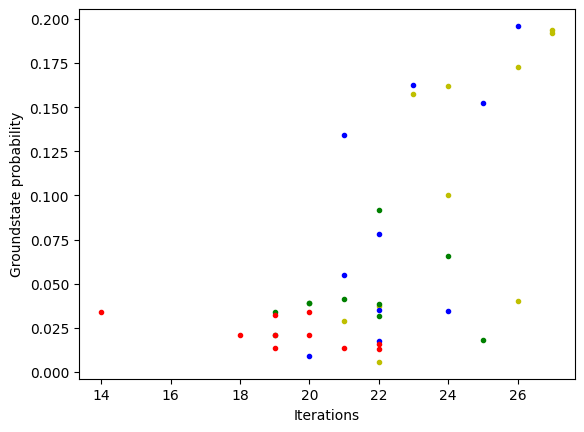

In [9]:
#Både denna och nästa cell ska tas bort så att dataanalysen istället görs i Data_analysis notebooken 

fig, ax = plt.subplots()
for prob_vector in data_library['data_for_alpha_1.0']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'y.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.25']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'b.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.1']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'g.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.05']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'r.', linewidth=0.01)
plt.xlabel('Iterations')
plt.ylabel('Groundstate probability')
plt.show()

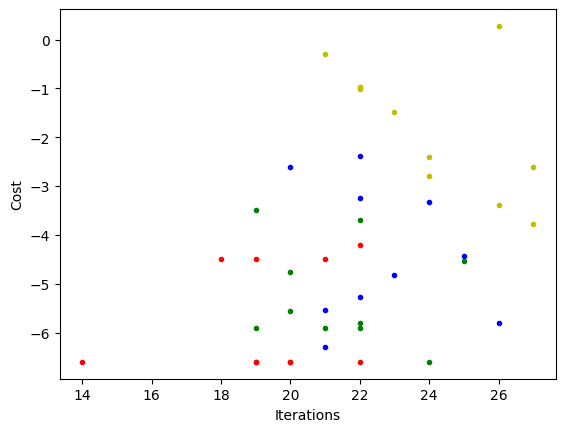

In [10]:
fig, ax = plt.subplots()
for cost_vector in data_library['data_for_alpha_1.0']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'y.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.25']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'b.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.1']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'g.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.05']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'r.', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()